In [1]:
import numpy as np
from scipy import linalg
import scipy.io as sio
import random
from statistics import mean
from math import pi, sin, cos

from API.camera import Camera
from API.functions3D import *
from API.linear_solver import *
from API.nonlinear_solver import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d

import pickle

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<div style="font-family: Times New Roman MS">
    <p><center><u><b>ECE 278A</b>: Digital Image Processing</u></center></p>
    <p><center><u>Topic Presentation</u></center></p>
    <h1 style="font-family: Times New Roman; margin-bottom: -10px"><center>Reconstruction via triangulation (line of sight, linear, nonlinear methods)</center></h1>
     <p><center><i><b>Anirban Banik, Utso Majumder</b></i></center></p>
     <p><center>Department of Electrical & Computer Engineering, UCSB</center></p>
 </div>
<center><img src="figs/UC-Santa-Barbara-seal-Navy RGB.png" width=300px alt="default"/></center>
 

<div style="font-family: Trebuchet MS">
    <h2 style="font-family: Trebuchet MS; letter-spacing: 0.5px"><center>Outline</center></h2>
    <ul>
        <li>Triangulation</li>
        <li> Image Formation and building the Camera</li>
        <li>Line of Sight</li>
        <li>Linear Reconstruction</li>
        <li>Reconstruction with noisy dataset</li>
        <li>Nonlinear Reconstruction (using Gauss Newton Method)</li>
<!--         <li>Adaptive Reconstruction (and onto our project)</li> -->
        <li>Recent publication</li>
    </ul>
</div>

# Triangulation

### Overview
One of the most fundamental problems in multiple view geometry is the problem of triangulation, the process of determining the location of a 3D  point given its projections into two or more images.

Triangulation determines :
- Object's 3D profile.
- 3D coordinates of any point in the profile.

<center><img src="figs/3D_Reconstruct.webp" width=700px alt="default"/></center>

### Advantages 
- Enhanced Perception
- Depth Estimation
- Object Recognition and Tracking
- Scene Understanding

<center><img src="figs/Triangulation_1.png" width=500px alt="default"/></center>

### Applications
- Robotics
- AR/VR
- Biological Imaging

# Camera Model for Image Formation
## (Paraxial Refraction Model)


<center><img src="figs/triangulation1.png" width=500 px alt="default"/></center>

The projection of a real-world point $P$ to the digital image plane is:
$$p = M P$$



Here $M$ is the camera matrix, which can be written as :
$$M 
= 
\begin{bmatrix}
(f+z_0)k & 0 & c_x \\
0 & (f+z_0)l & c_y \\
0 & 0 & 1 \end{bmatrix}
\begin{bmatrix}
I_3 & 0
\end{bmatrix}
\begin{bmatrix}
R & T \\
0 & 1
\end{bmatrix}
= K  \begin{bmatrix}
I_3 & 0
\end{bmatrix}
\begin{bmatrix}
R & T \\
0 & 1
\end{bmatrix}
$$

where :
- $K$ is the camera intrinsic matrix, consisting of :
  - $f$ -> Focal length.
  - $c_x$, $c_y$ -> Camera offset parameters.
  - $k$, $l$ -> Scaling parameters (pixels/cm).
  - $z_0$ -> Distance between the focal point and image plane.
- $R$ -> extrinsic rotation,
- $t$ -> extrinsic translation.

<center><img src="figs/Image_Formation.png" width=500 px alt="default"/></center>


# 2D Image Formation from a 3D point cloud

In this section we show how we get the 2D projections of a 3D point cloud if we know the camera matrices.

<center><img src="figs/Triangulation.png" width=500px alt="default"/></center>

In [2]:
array_object=np.load('NPZ/transformed_point_cloud_array_skeleton.npz')

transformed_point_cloud_arr_npz=array_object['transformed_point_cloud_array']
point_cloud_arr_npz=array_object['point_cloud_array']
box_sides=array_object['dist']

In [3]:
# Downsample points in the point cloud

downsampled_dataset_size = 100000
downsampled_dataset=random_downsampler(point_cloud_arr_npz, downsampled_dataset_size)

x_component=extract_orthogonal_component(downsampled_dataset, 0)
y_component=extract_orthogonal_component(downsampled_dataset, 1)
z_component=extract_orthogonal_component(downsampled_dataset, 2)

Downsampled dataset size: 100000


In [4]:
num_points = downsampled_dataset_size

P_x_array = x_component
P_y_array = y_component
P_z_array = z_component

P_array = np.zeros((num_points, 3))

for index in range(num_points):
    P_array[index] = np.array([P_x_array[index], P_y_array[index], P_z_array[index]])

### Visualize point cloud in 3D space

Text(0.5, 0, 'Z_axis')

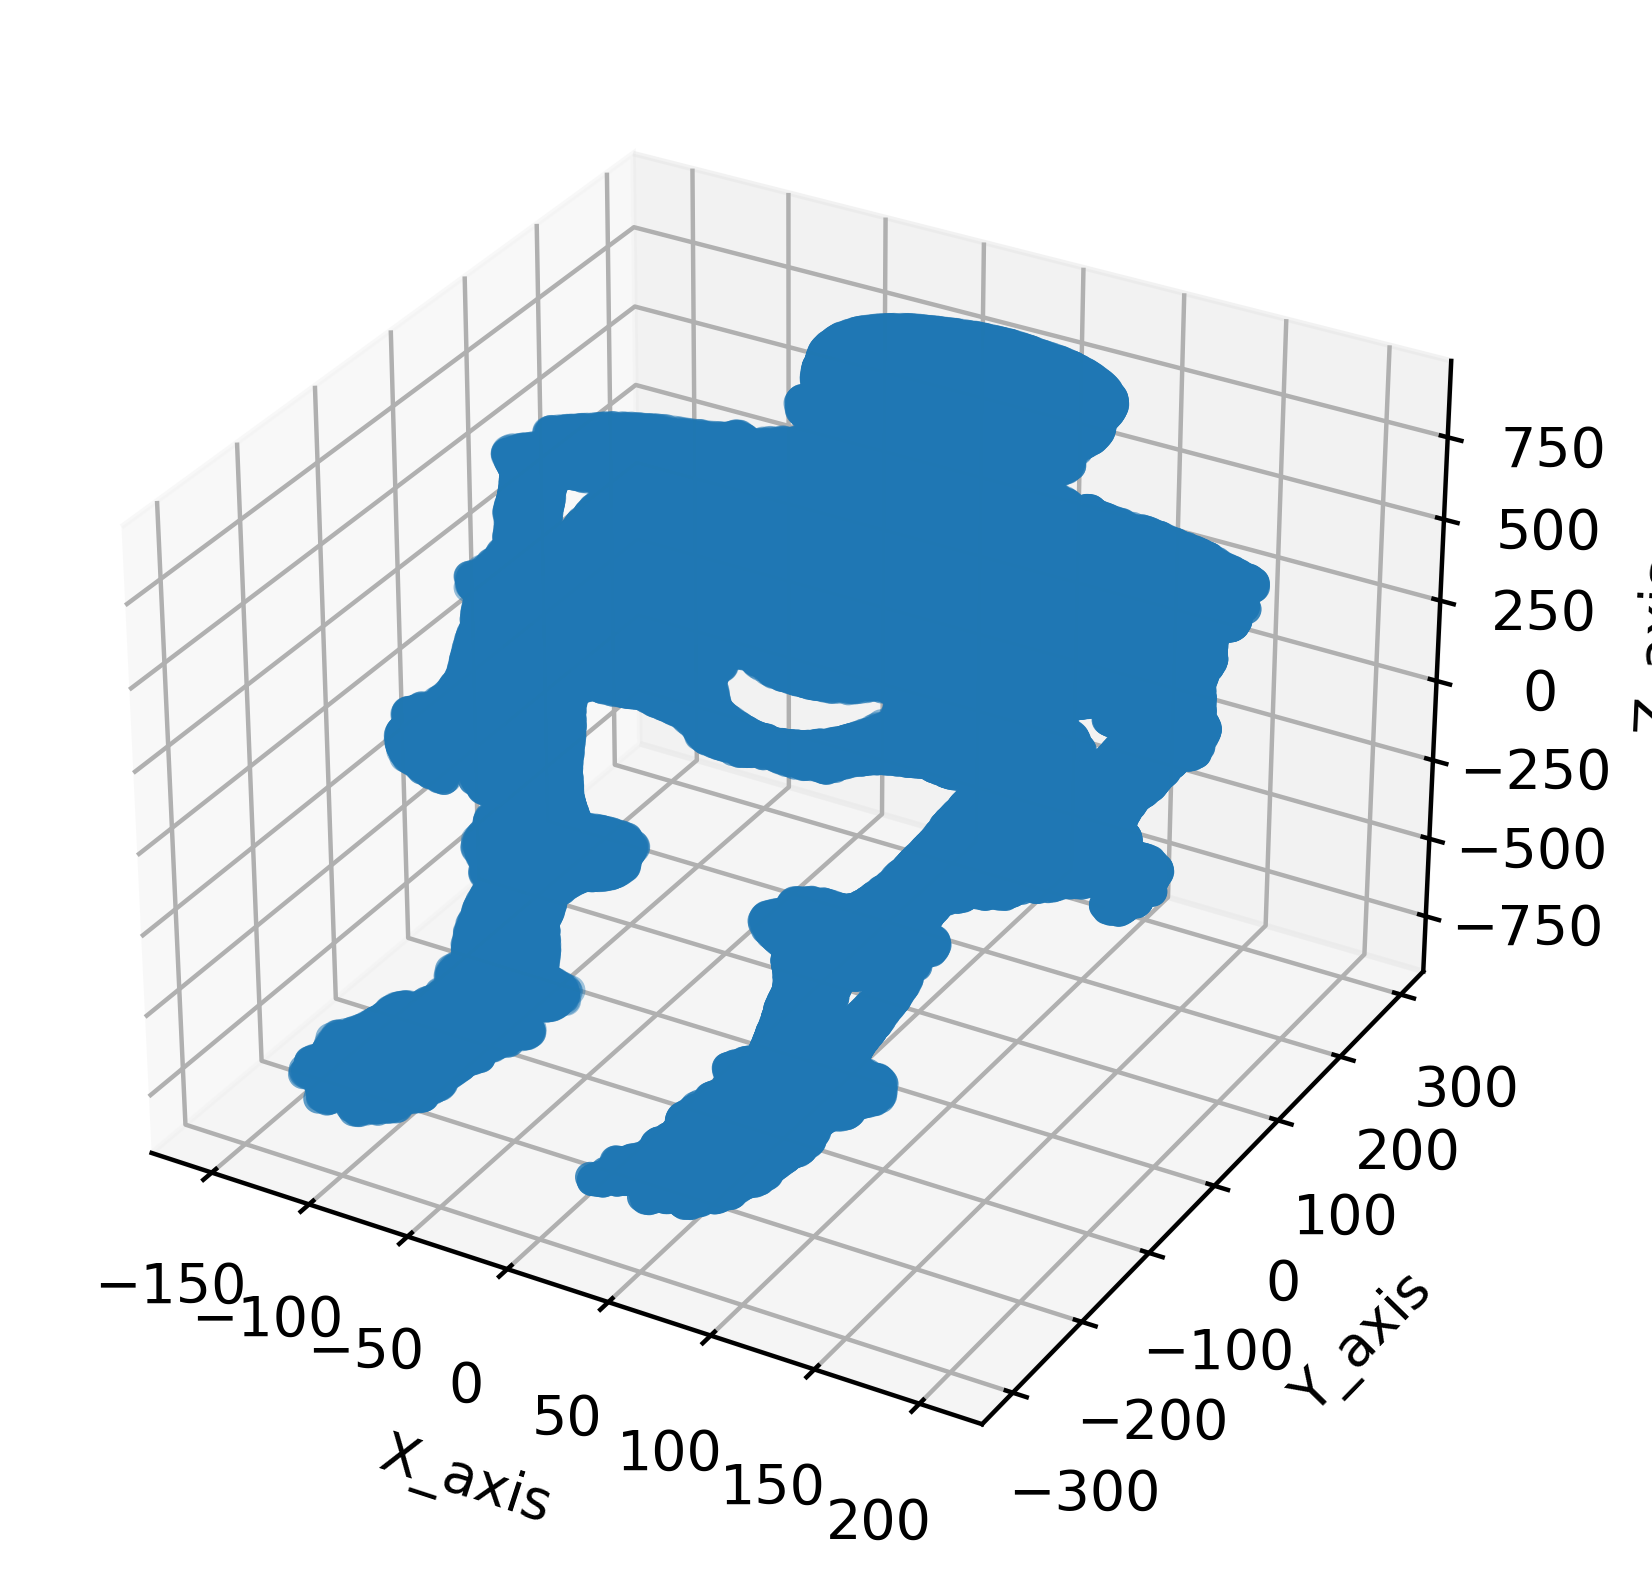

In [5]:
# Visualize P in 3D plot

fig = plt.figure(dpi=400)
ax_3d = fig.add_subplot(projection='3d')

ax_3d.scatter(P_array[:, 0], P_array[:, 1], P_array[:, 2], ".")

ax_3d.set_xlabel("X_axis")
ax_3d.set_ylabel("Y_axis")
ax_3d.set_zlabel("Z_axis")

### Camera configurations

In [6]:
num_cameras = 6

# z (Camera Distance along the z-axis, outside the bounding box (Can be a random value))
z = 6*max(box_sides)

# The Cameras are homogeneous, so keep the intrinsic parameters the same
f = 1
z0 = 1
k = 1
l =1
c_x = 0
c_y = 0

alpha_array = [0, 0, 0, 0, 0, 0]
beta_array = [0, np.pi/4, 3*np.pi/4, np.pi, 5*np.pi/4, 7*np.pi/4]
gamma_array = [0, 0, 0, 0, 0, 0]

x_array = [0, z/np.sqrt(2), z/np.sqrt(2), 0, -z/np.sqrt(2), -z/np.sqrt(2)]
y_array = [0, 0, 0, 0, 0, 0]
z_array = [z, z/np.sqrt(2), -z/np.sqrt(2), -z, -z/np.sqrt(2), z/np.sqrt(2)]

### Visualize the camera setup in 3D space

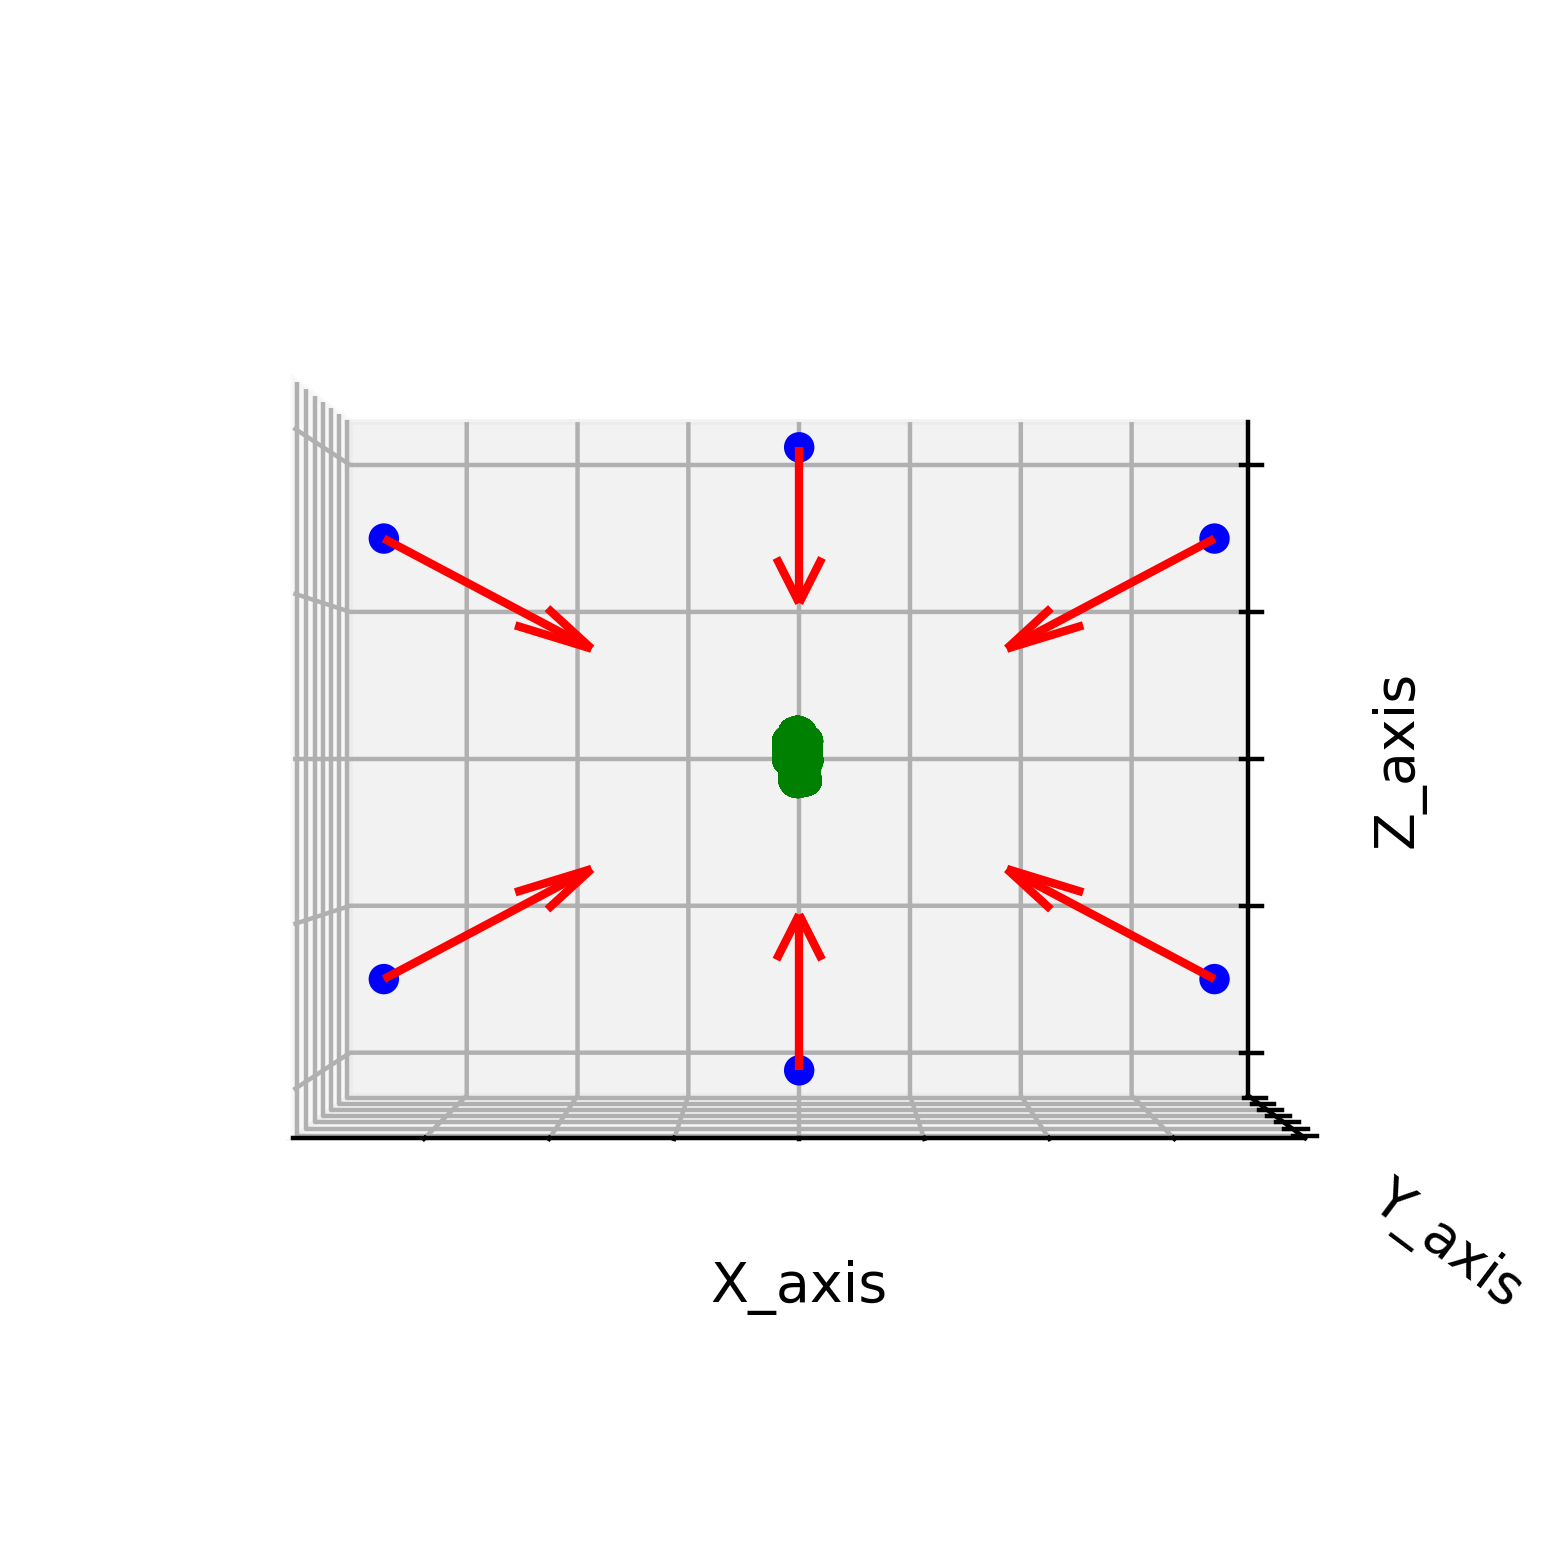

In [7]:
# Visualize P in 3D plot

elev=0
azim=90
roll=0

fig = plt.figure(dpi=400)
ax_3d = fig.add_subplot(projection='3d')
ax_3d.view_init(elev, azim, roll)

ax_3d.scatter(P_array[:, 0], P_array[:, 1], P_array[:, 2], ".", color="green")

ax_3d.set_xlabel("X_axis")
ax_3d.set_ylabel("Y_axis")
ax_3d.set_zlabel("Z_axis")

ax_3d.grid(True)

ax_3d.set_xticklabels([])
ax_3d.set_yticklabels([])
ax_3d.set_zticklabels([])

ax_3d.scatter(x_array, y_array, z_array, ".", color="blue")

u_array = []
v_array = []
for beta_idx in range(len(beta_array)):
    u_array.append(-cos(beta_array[beta_idx]))
    v_array.append(-sin(beta_array[beta_idx]))

for i in range(len(x_array)):
    ax_3d.quiver(x_array[i], y_array[i], z_array[i], v_array[i], 0, u_array[i], length = 5000, normalize = True, color="red")

### Setting up the camera dictionary
#### Note :
Let the extrinsic calibration of the camera wrt Ground coordinates be :
1. $\alpha$, $\beta$, $\gamma$ - rotations along X-Axis, Y-Axis, and Z-Axis respectively.
2. $x$, $y$, $z$ - translations along X-Axis, Y-Axis, and Z-Axis respectively.

Consider the camera matrix for 2D projection from the camera perspective. 

In [8]:
camera_dict = {}

for idx in range(num_cameras):
    cam = Camera(idx+1)
    cam.set_intrinsic_matrix_params(f, z0, k, l, c_x, c_y)

    # Ground to Camera Perspective (Have to invert the Rotation and Translation values)
    cam.set_extrinsic_rot_matrix_params(-alpha_array[idx], -beta_array[idx], -gamma_array[idx])
    cam.set_extrinsic_translation_matrix_params(-x_array[idx], -y_array[idx], -z_array[idx])

    rotation_matrix = cam.get_3D_rotation_matrix()
    translation_matrix = cam.get_3D_translation_matrix()
    intrinsic_matrix = cam.get_intrinsic_matrix()

    camera_dict.update({idx : {"Camera ID": cam.camera_id, "Camera Obj": cam, 
                                 "Camera Matrix": cam.get_camera_matrix(intrinsic_matrix, rotation_matrix, translation_matrix)}})

### Use the Camera matrices to get the 2D representation for the 3D image

In [9]:
p_array_2d_dict = {}


for camera_index in range(num_cameras):
    p_array_2d_dict.update({camera_index:{"Camera ID": camera_index+1, "Data": {}}})

    for point_index in range(num_points):
        point_info = P_array[point_index].reshape((3, 1)) # Change to a column matrix 
        P_3d_homogeneous = np.block([[point_info], [1]]) # 3D homogeneous point representation
        p_2d_homogeneous = np.matmul(camera_dict[camera_index]["Camera Matrix"], P_3d_homogeneous)

        p_2d_homogeneous_scaled = p_2d_homogeneous[:]/p_2d_homogeneous[-1]

        # A check for lesser values of scaling factor
        if(abs(p_2d_homogeneous[-1]) < 0.01):
            print(f"Less value of scaling factor:{p_2d_homogeneous} ")
            print(f"3D Point: {P_3d_homogeneous}")
        
        p_array_2d_dict[camera_index]["Data"].update({point_index: {"3D": point_info, "2D": p_2d_homogeneous_scaled[0:-1]}})

### Plot the 2D image points for each camera

Parameters of Camera 1: 
Rotation along X: 0.0 degrees
Rotation along Y: 0.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: 0
Translation along Y: 0
Translation along Z: 10000.502197265625


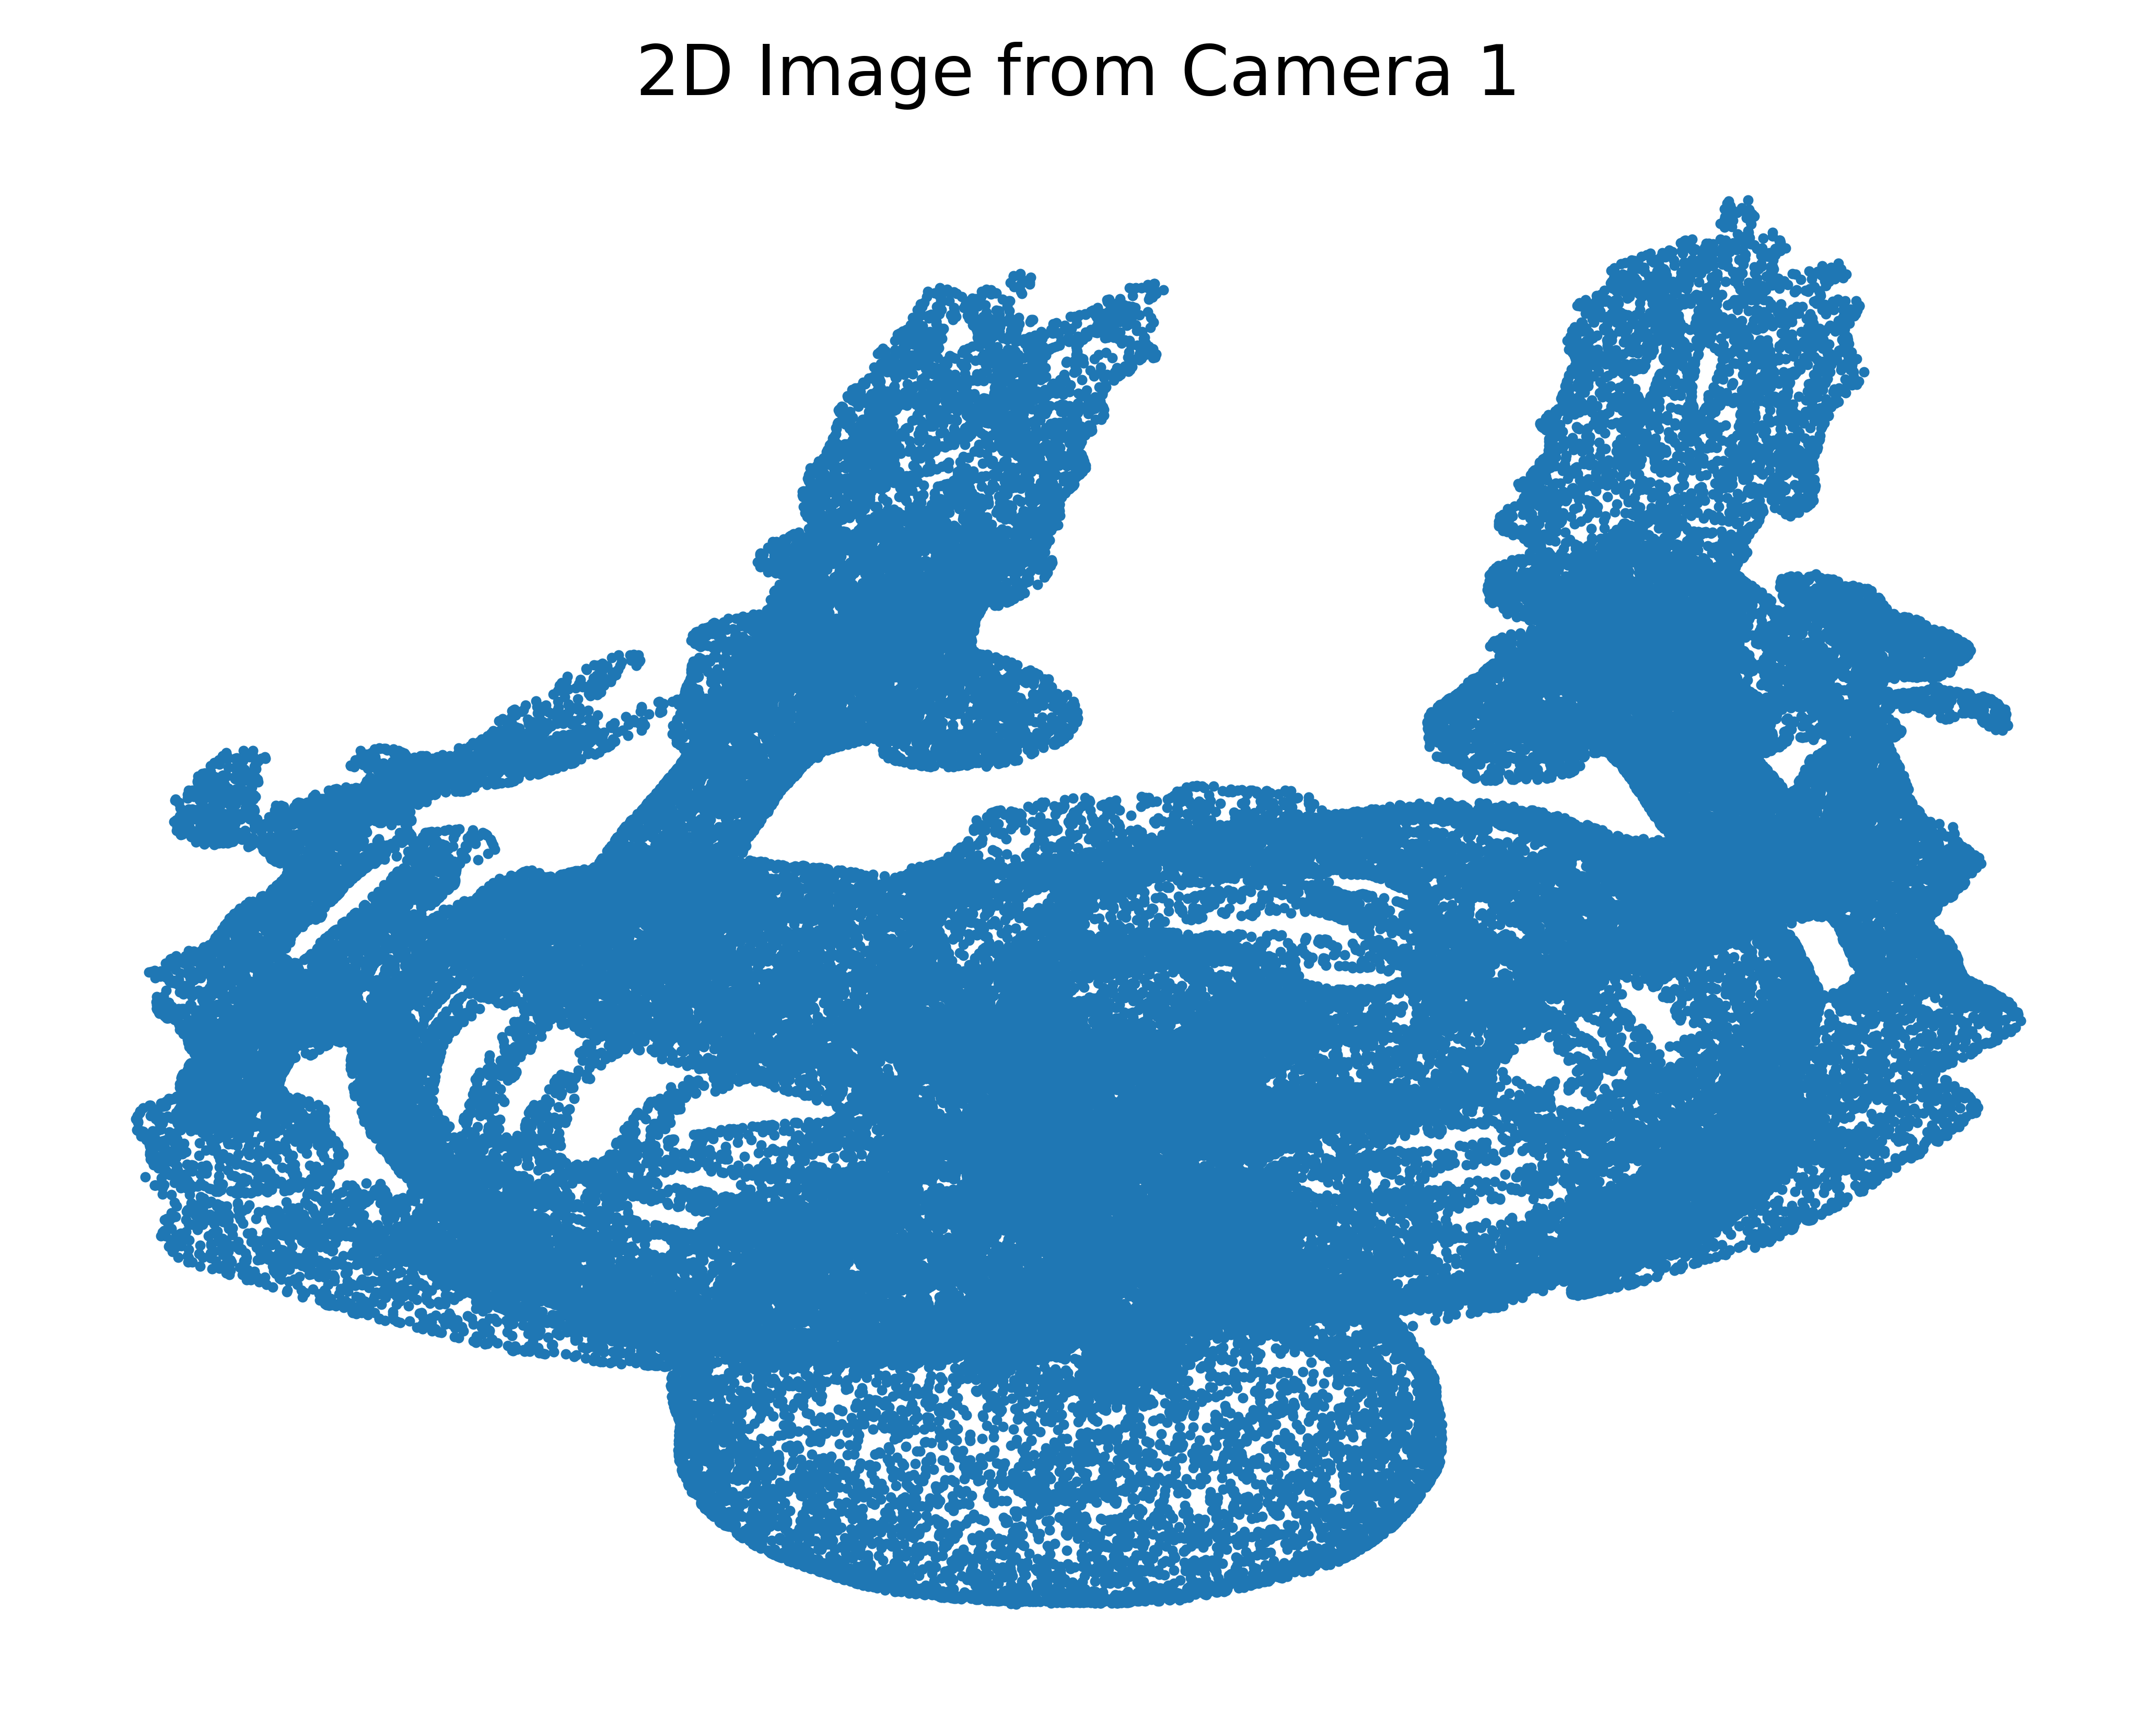

Parameters of Camera 2: 
Rotation along X: 0.0 degrees
Rotation along Y: 45.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: 7071.422918957492
Translation along Y: 0
Translation along Z: 7071.422918957492


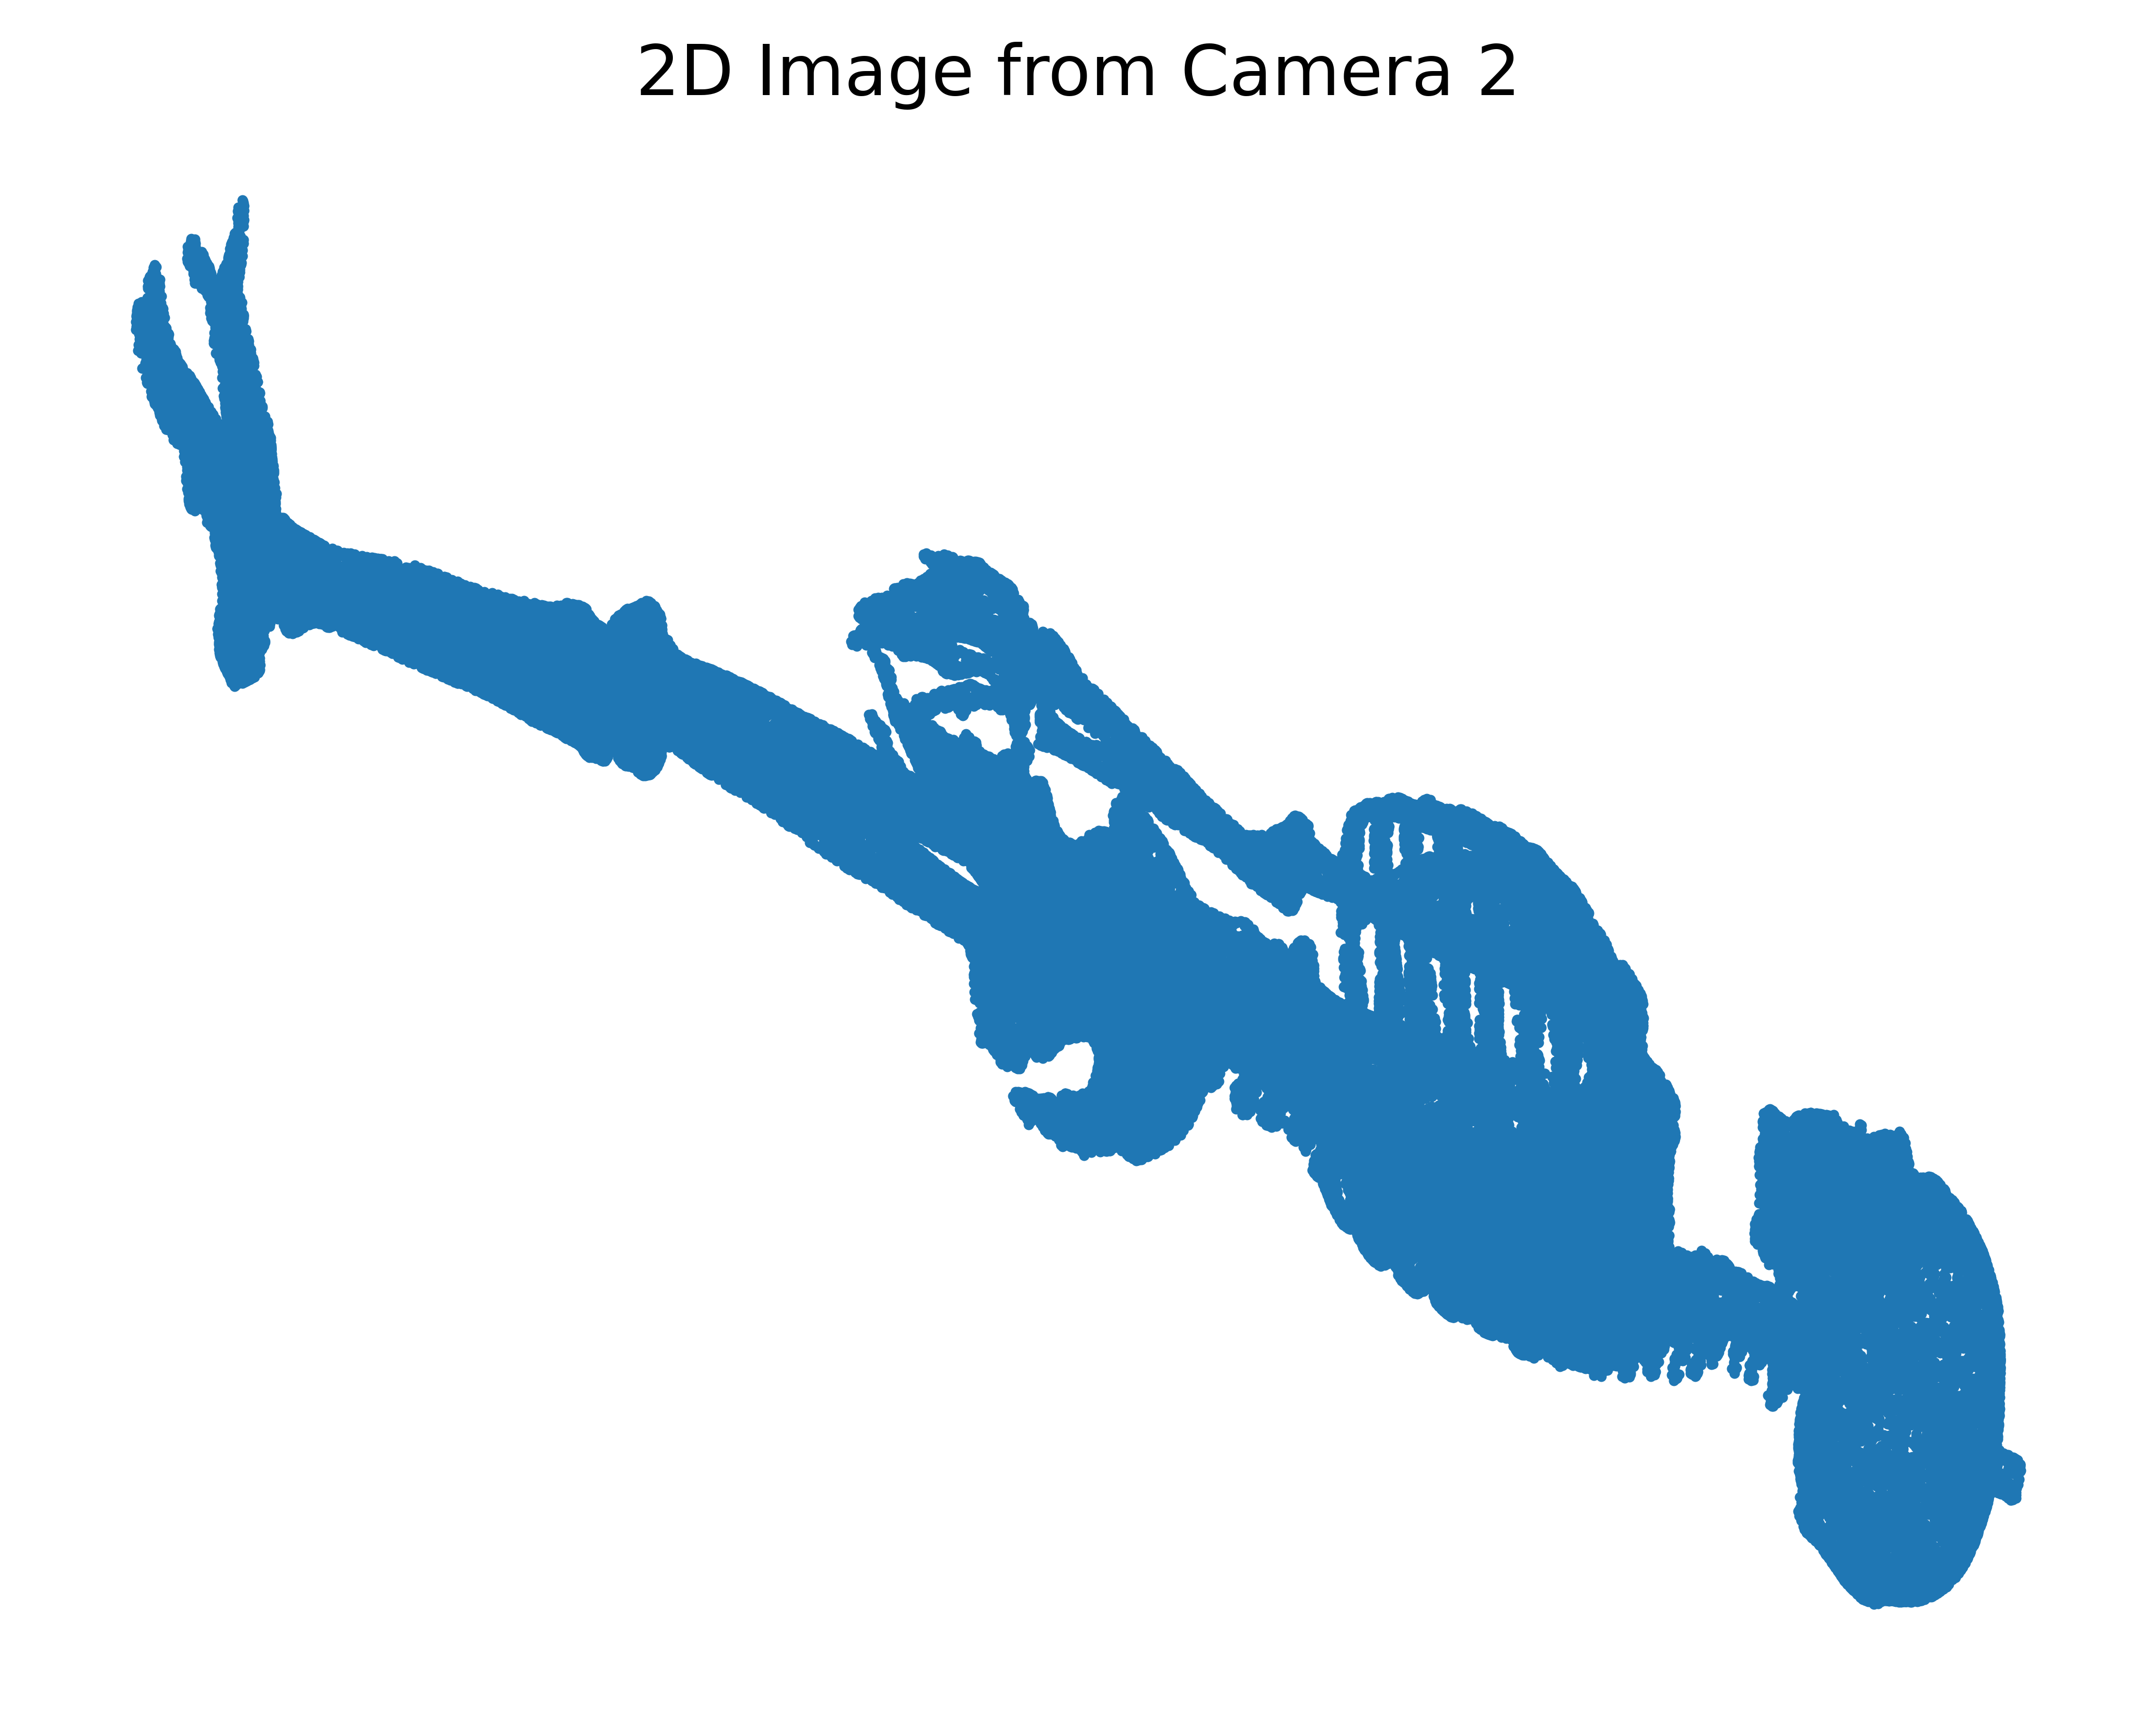

Parameters of Camera 3: 
Rotation along X: 0.0 degrees
Rotation along Y: 135.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: 7071.422918957492
Translation along Y: 0
Translation along Z: -7071.422918957492


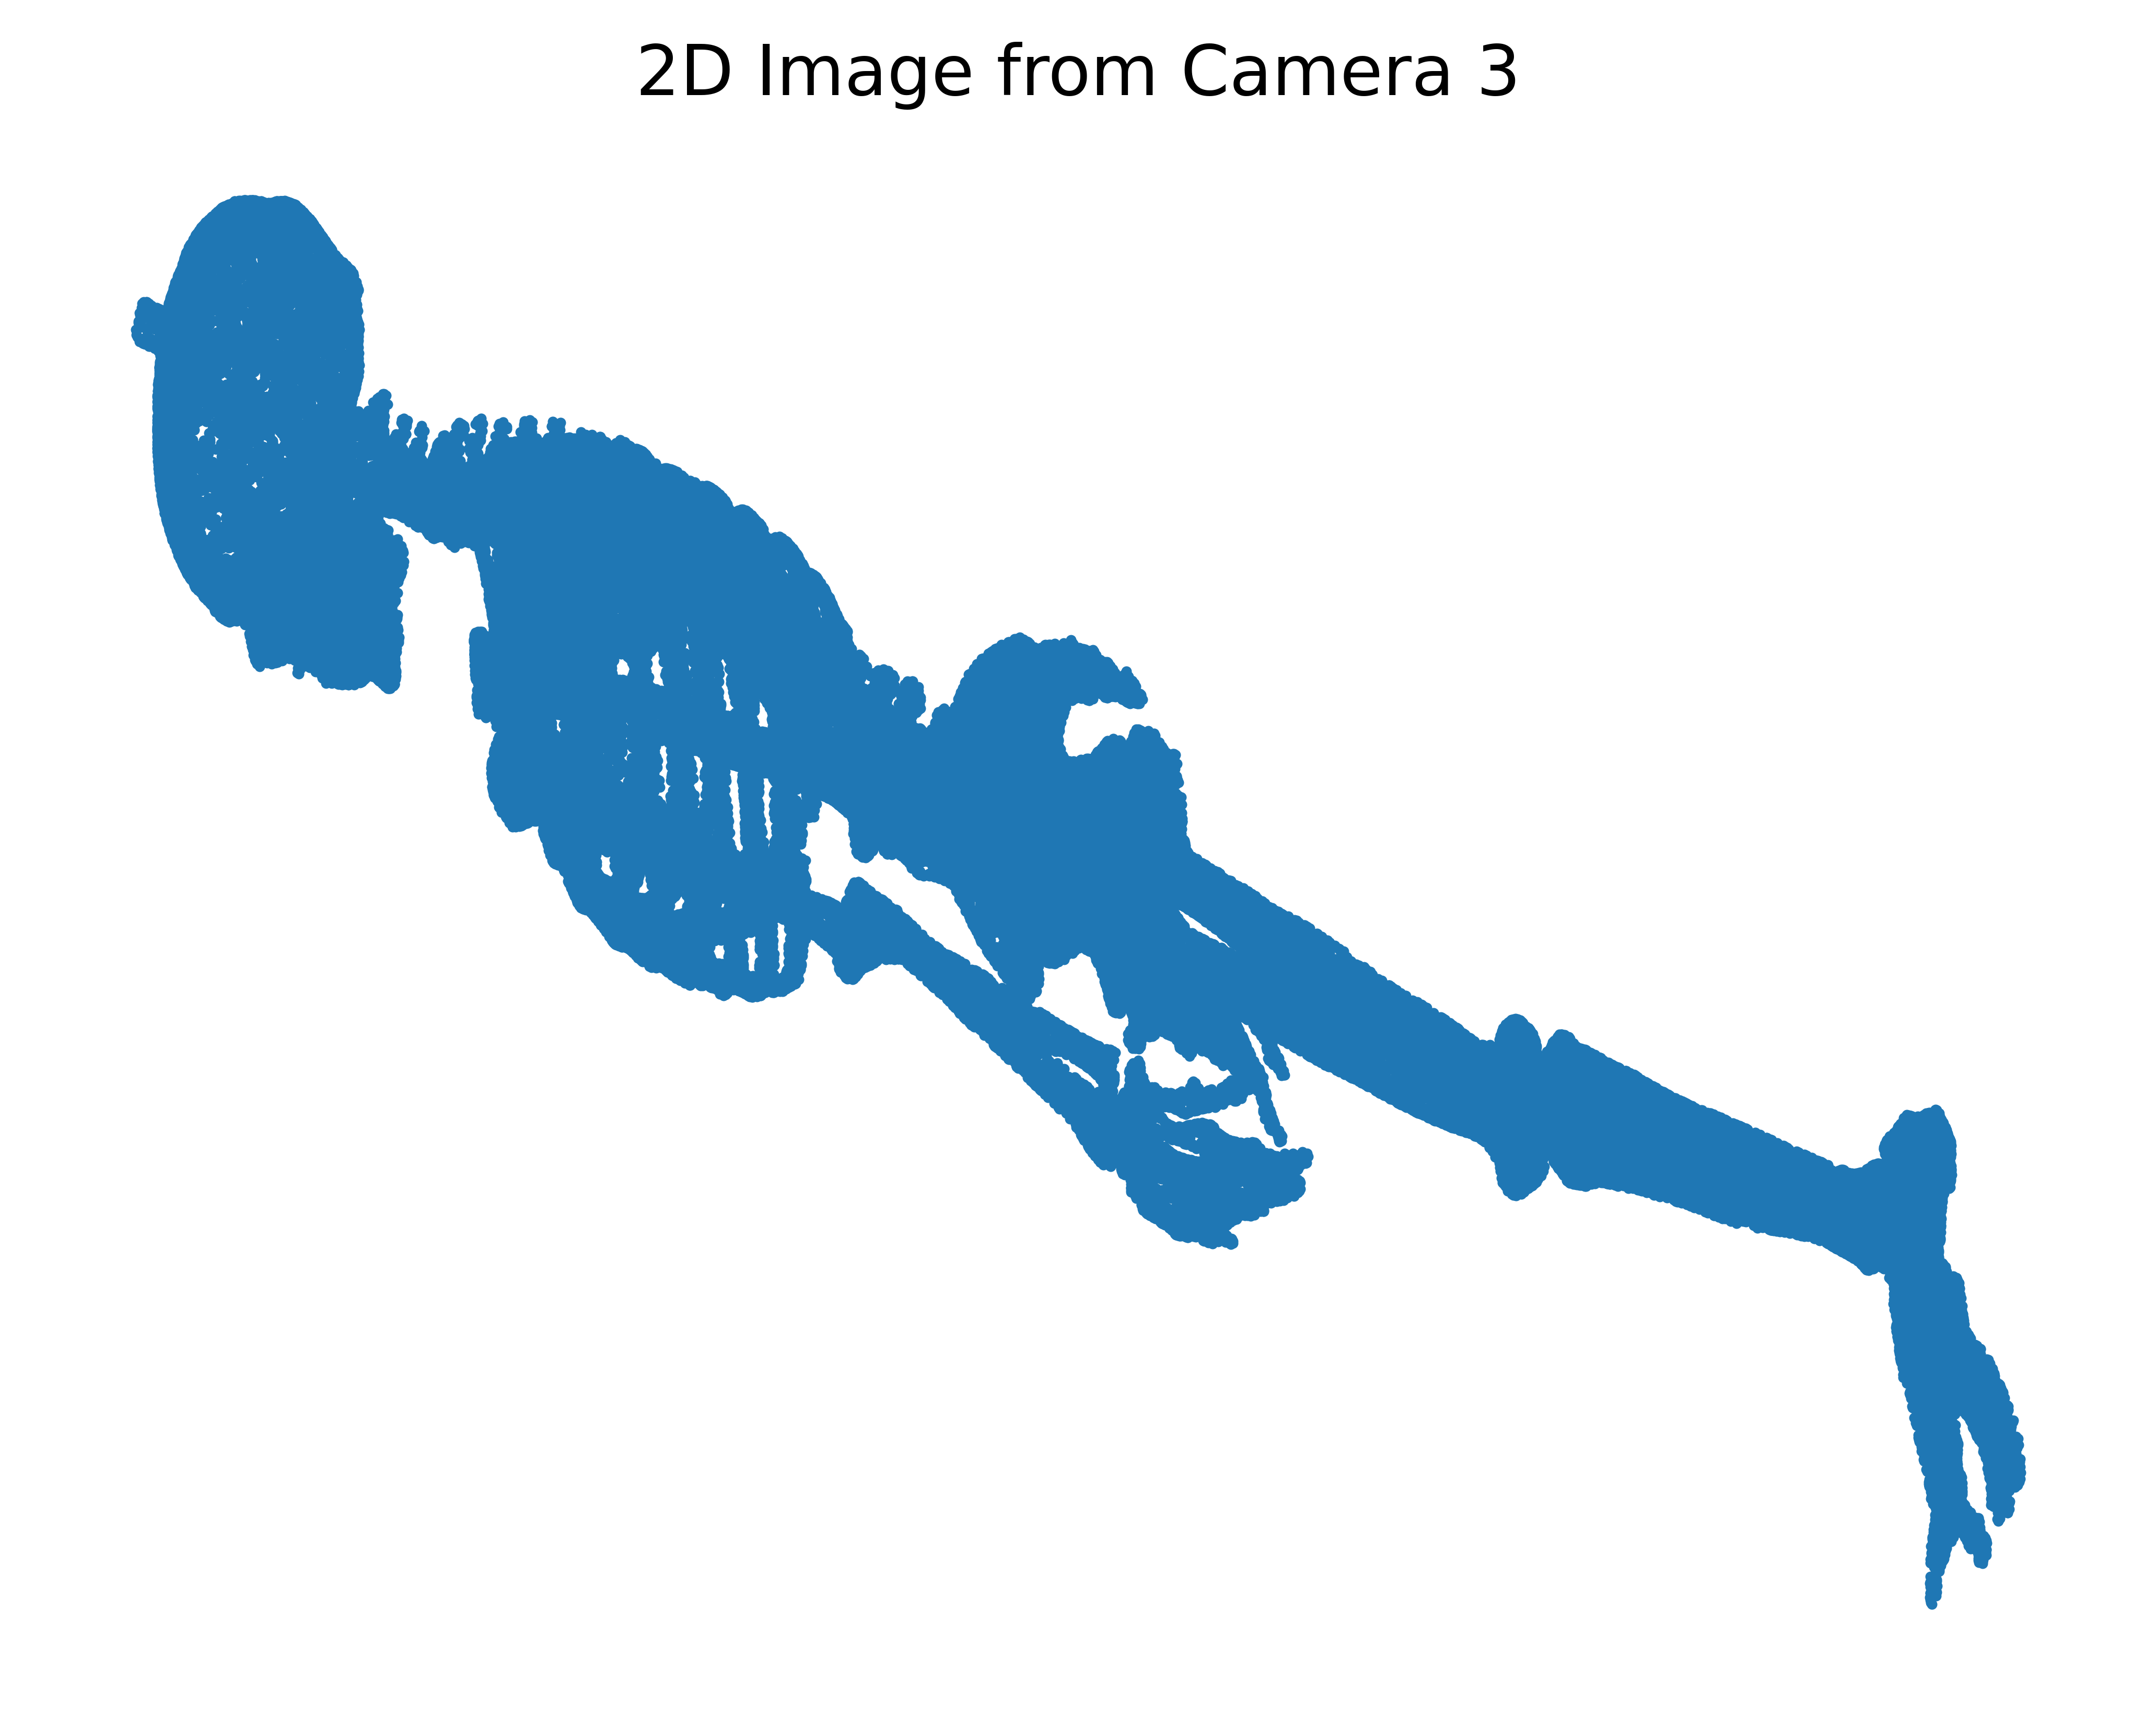

Parameters of Camera 4: 
Rotation along X: 0.0 degrees
Rotation along Y: 180.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: 0
Translation along Y: 0
Translation along Z: -10000.502197265625


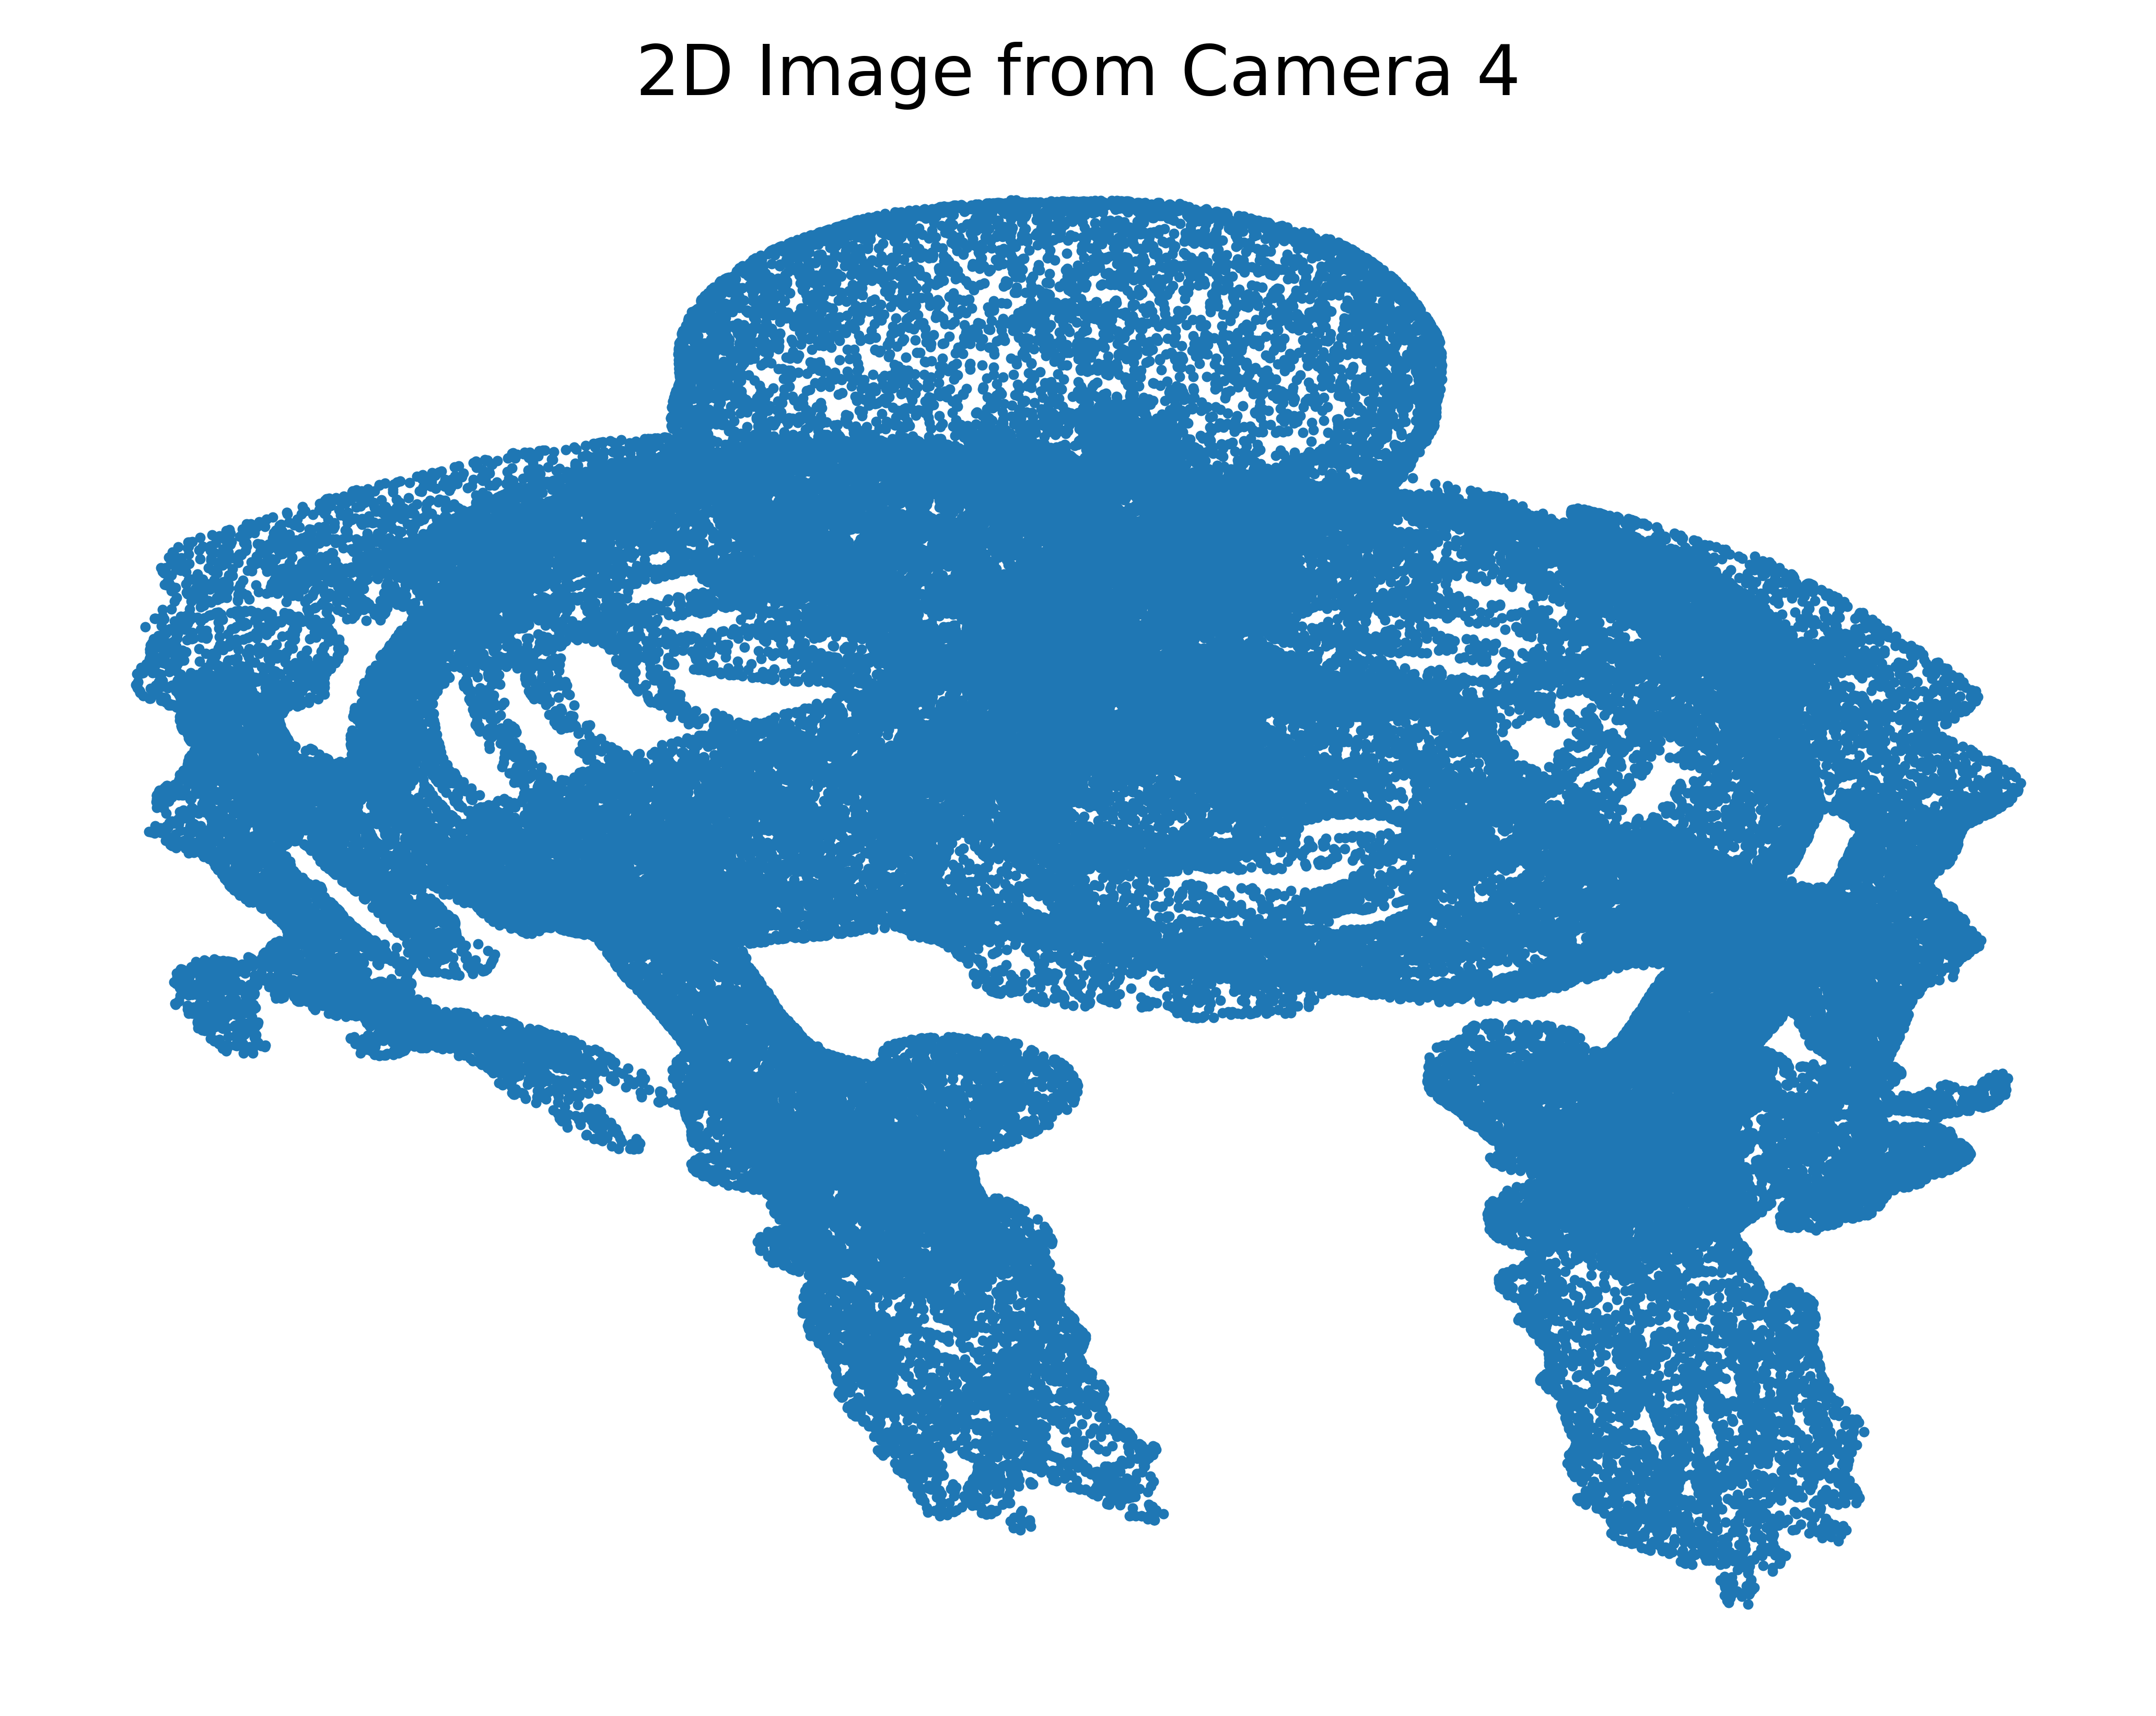

Parameters of Camera 5: 
Rotation along X: 0.0 degrees
Rotation along Y: 225.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: -7071.422918957492
Translation along Y: 0
Translation along Z: -7071.422918957492


Parameters of Camera 6: 
Rotation along X: 0.0 degrees
Rotation along Y: 315.0 degrees
Rotation along Z: 0.0 degrees
Translation along X: -7071.422918957492
Translation along Y: 0
Translation along Z: 7071.422918957492


In [10]:
for camera_index in range(num_cameras):
    x_pos_arr = []
    y_pos_arr = []
    
    for point_index, point_info in p_array_2d_dict[camera_index]["Data"].items():
        x_pos_arr.append(point_info["2D"][0][0])
        y_pos_arr.append(point_info["2D"][1][0])
    
    
    print("Parameters of Camera "+str(p_array_2d_dict[camera_index]["Camera ID"])+": ")
    print("Rotation along X: {} degrees".format((-camera_dict[camera_index]["Camera Obj"].rot_x)*(180/(pi))))
    print("Rotation along Y: {} degrees".format((-camera_dict[camera_index]["Camera Obj"].rot_y)*(180/(pi))))
    print("Rotation along Z: {} degrees".format((-camera_dict[camera_index]["Camera Obj"].rot_z)*(180/(pi))))
    print("Translation along X: {}".format(-camera_dict[camera_index]["Camera Obj"].translate_x))
    print("Translation along Y: {}".format(-camera_dict[camera_index]["Camera Obj"].translate_y))
    print("Translation along Z: {}".format(-camera_dict[camera_index]["Camera Obj"].translate_z))
    
    
    plt.figure(dpi=800)
    plt.plot(x_pos_arr, y_pos_arr, ".", markersize=1.6)
#              , cmap="viridis")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.title("2D Image from Camera "+str(p_array_2d_dict[camera_index]["Camera ID"]))
    plt.axis("off")
    plt.show()

# Lines of Sight

Here, we trace one ray for each of $N=2$ cameras from a point $P$ in the global 3D space that transform to points $p$ and $p'$ in the two 2D image planes.

Known parameters:
- Camera extrinsic and instrinsic parameters
- Points $p$, $p'$ in the image planes

Unkown parameters:
- 3D point, $P$

<center><img src="figs/Triangulation_Basic.png" width=500px alt="default"/></center>

#### Methodology:
- Join $O_i$ to the corresponding point $p_i$ (<u>$O_1p$ and $O_2p'$ are the lines here</u>)
- Extend the lines and find the point of intersection
- These are the two lines of sight that reconstruct the 3D point

#### Limitations:
- There maybe noise present in either the image ($p$ or $p'$), or the camera calibration ($M$ or $M'$)
- Lines of sight may never meet as they may fall in parallel planes

<!-- <center><img src="figs/Triangulation_Basic.png" width=500px alt="default"/></center> -->

# Linear Reconstruction

Here, we describe a simple linear triangulation method that solves the lack of an intersection point between rays. We are given two points in the images that correspond to each other. We will go through this with the help of an example where we want to reconstruct a 3D point using $N=2$ cameras and thus, $N=2$ 2D images.

These points are, 
$$\begin{equation}
p = MP = (x,y,1)\\ \text{ and }\\
p' = M'P = (x', y', 1)
\end{equation}$$

### Direct Linear Transformation (DLT)

Next, we play with a neat trick that applies for direction vectors, that is <u>the null result of outer product of a vector with itself</u>. Mathematically, this implies, for a given direction vector, $p$,

$$\begin{equation}
p \times p = 0
\end{equation}$$


# Triangulation via solving a system of linear equations (contd.)
Before we proceed any further, let us get a hold of the dimensions in each of these equations:
- $p$, $p'$ are $3\times1$ vectors
- $P$ is a $4\times1$ vector
- $M$ is a $3\times4$ matrix

Thus, by definition and identity,
$$
\begin{equation}
p \times MP = 0\\ \\
\implies 
\begin{bmatrix}
i_d & j_d & k_d\\
x & y & 1\\
M_1P & M_2P & M_3P\\
\end{bmatrix}=0
\end{equation}
$$ 

Here, $M_i$ refers to the $i^{th}$ row of the camera matrix, $M$, and $i_d$, $j_d$ and $k_d$ are the unit vectors in the x, y and z directions respectively in the global 3D space.

We will expand this in the next sub-slide.

From this outer product, we obtain three equalities to form three constraints that follow:

$$
\begin{equation}
x(M_3P)-M_1P=0\\
y(M_3P)-M_2P=0\\
x(M_2P)-y(M_1P)=0\\
\end{equation}
$$
Neat right?

Now let us proceed to do this for another camera, where the camera matrix is defined as $M'$ and the 2D projected point of the 3D point $P$, on this camera's 2D image is $p'$. So if we follow the same procedure,
$$\begin{equation}
p' \times M'P = 0\\ \\
\implies 
\begin{bmatrix}
i & j & k\\
x' & y' & 1\\
M_1'P & M_2'P & M_3'P\\
\end{bmatrix} = 0
\end{equation}
$$
And obtain another system of linear equations,
$$
\begin{equation}
x'(M_3'P)-M_1'P=0\\
y'(M_3'P)-M_2'P=0\\
x'(M_2'P)-y'(M_1'P)=0\\
\end{equation}
$$

Once again, this example is built on $N=2$ cameras, but this framework can be extended to any arbitrary $N$ number of cameras. 

But which equations can be used for constraints? <u>Those equations with atleast one free variable</u>.

Next, we construct a constraint matrix, $A$ in which every pair of rows are the constraints obtained from a particular camera. For this example, 


$$
\begin{equation}
A=
\begin{bmatrix}
x(M_3)-M_1\\
y(M_3)-M_2\\
x'(M_3')-M_1'\\
y'(M_3')-M_2'\\
\end{bmatrix}
\end{equation}
$$


Notice, that $P$ is not present in this representation. This is because, we will form a matrix equation to find P through A such that,
$$
\begin{equation}
AP=0
\end{equation}
$$

Since, we are conducting this analysis through homogeneous image point representations, this method is thus called <b>Homogeneous Direct Linear Transformation</b>.

Thus, we realize that $P$ is the null space of $A$, and we can easily find $P$ using any matrix operations and algorithms, for example Singular Value Decomposition (SVD). 

A key point to remember is that each camera contributes 2 constraints to the matrix $A$. Thus, for $N$ cameras, dimensions of $A$ will be $2N\times4$

Now, if we consider an SVD implementation, we implement the following steps:
- Write the constraint matrix, $A$ as $A=\text{U}\Sigma\text{V}^T$ where, 
    - U is a $4\times4$ orthogonal matrix
    - U is a $4\times4$ diagonal matrix with singular values on its diagonal
    - V is a $4\times4$ orthogonal matrix
- The null space of $A$ consists of vectors P that satisfy $AP=0$, These vectors are found in the columns of V corresponding to the zero singular values in $\Sigma$
- After performing the SVD, identify the columns of V (or rows of V$^T$) that correspond to zero singular values. The corresponding vectors form the basis of the null space.

#### Limitations:
- This method is not suitable for projective reconstruction, since it is not projective invariant
- It is not immune to noise most of the times. It cannot find a solution in case of most types of additive noise patterns

## For N=6 cameras, and no retrieval noise

Now, let us demonstrate the action of linear reconstruction on a dataset of 2D images simulated by $N=6$ cameras that we have oriented. Here, our assumptions of transformation in a noiseless environment. 



In [11]:
with open('PKL/saved_points_dictionary_skeleton.pkl', 'rb') as p_array_2d_dict_file:
    p_array_2d_dict = pickle.load(p_array_2d_dict_file)
    
with open('PKL/saved_camera_dictionary_skeleton.pkl', 'rb') as camera_dict_file:
    camera_dict = pickle.load(camera_dict_file)
    
num_cameras = 6
num_points = 100000

In [12]:
def get_camera_partition_for_2D_points(p_array_2d_dict):
    point_set_partition_dict = {}

    for point_index in range(num_points):
        camera_idx_array = [cam_index for cam_index in range(num_cameras) if point_index in p_array_2d_dict[cam_index]["Data"].keys()]
        
        if len(camera_idx_array) > 1:
            point_set_partition_dict.update({point_index:camera_idx_array})

    return point_set_partition_dict

In [13]:
point_set_partition_dict = get_camera_partition_for_2D_points(p_array_2d_dict)

In [14]:
P_3D_array = []
error = []
for point_index, camera_idx_list in point_set_partition_dict.items():

#     print("Point : {}".format(point_index))

    # Form the camera list and the point perspective array list in the respective cameras
    cam_mat_list = []
    point_perspective_array_list = []
    for camera_index in camera_idx_list:
        cam_mat_list.append(camera_dict[camera_index]['Camera Matrix'])

        point_perspective_array_list.append(p_array_2d_dict[camera_index]["Data"][point_index]["2D"])

    P_3D_temp_dyn = linear_reconstruct_scp_dyn(point_perspective_array_list, cam_mat_list)

    for row in range(len(P_3D_temp_dyn)):
        P_3D_temp_dyn[row] = P_3D_temp_dyn[row]/P_3D_temp_dyn[3]

    P_3D_temp_dyn=np.delete(P_3D_temp_dyn,3,0)
#     print(P_3D_temp_dyn)
#     print("Actual")
#     print(p_array_2d_dict[camera_index]["Data"][point_index]["3D"])
    error.append(np.linalg.norm(np.subtract(p_array_2d_dict[camera_index]["Data"][point_index]["3D"], P_3D_temp_dyn)) ** 2)
    P_3D_array.append(P_3D_temp_dyn.flatten())

In [15]:
# np.sqrt(np.divide(error,len(error)))
# np.mean(error)

In [16]:
# plt.figure(dpi=300)
# plt.plot(error, linewidth=0.18)

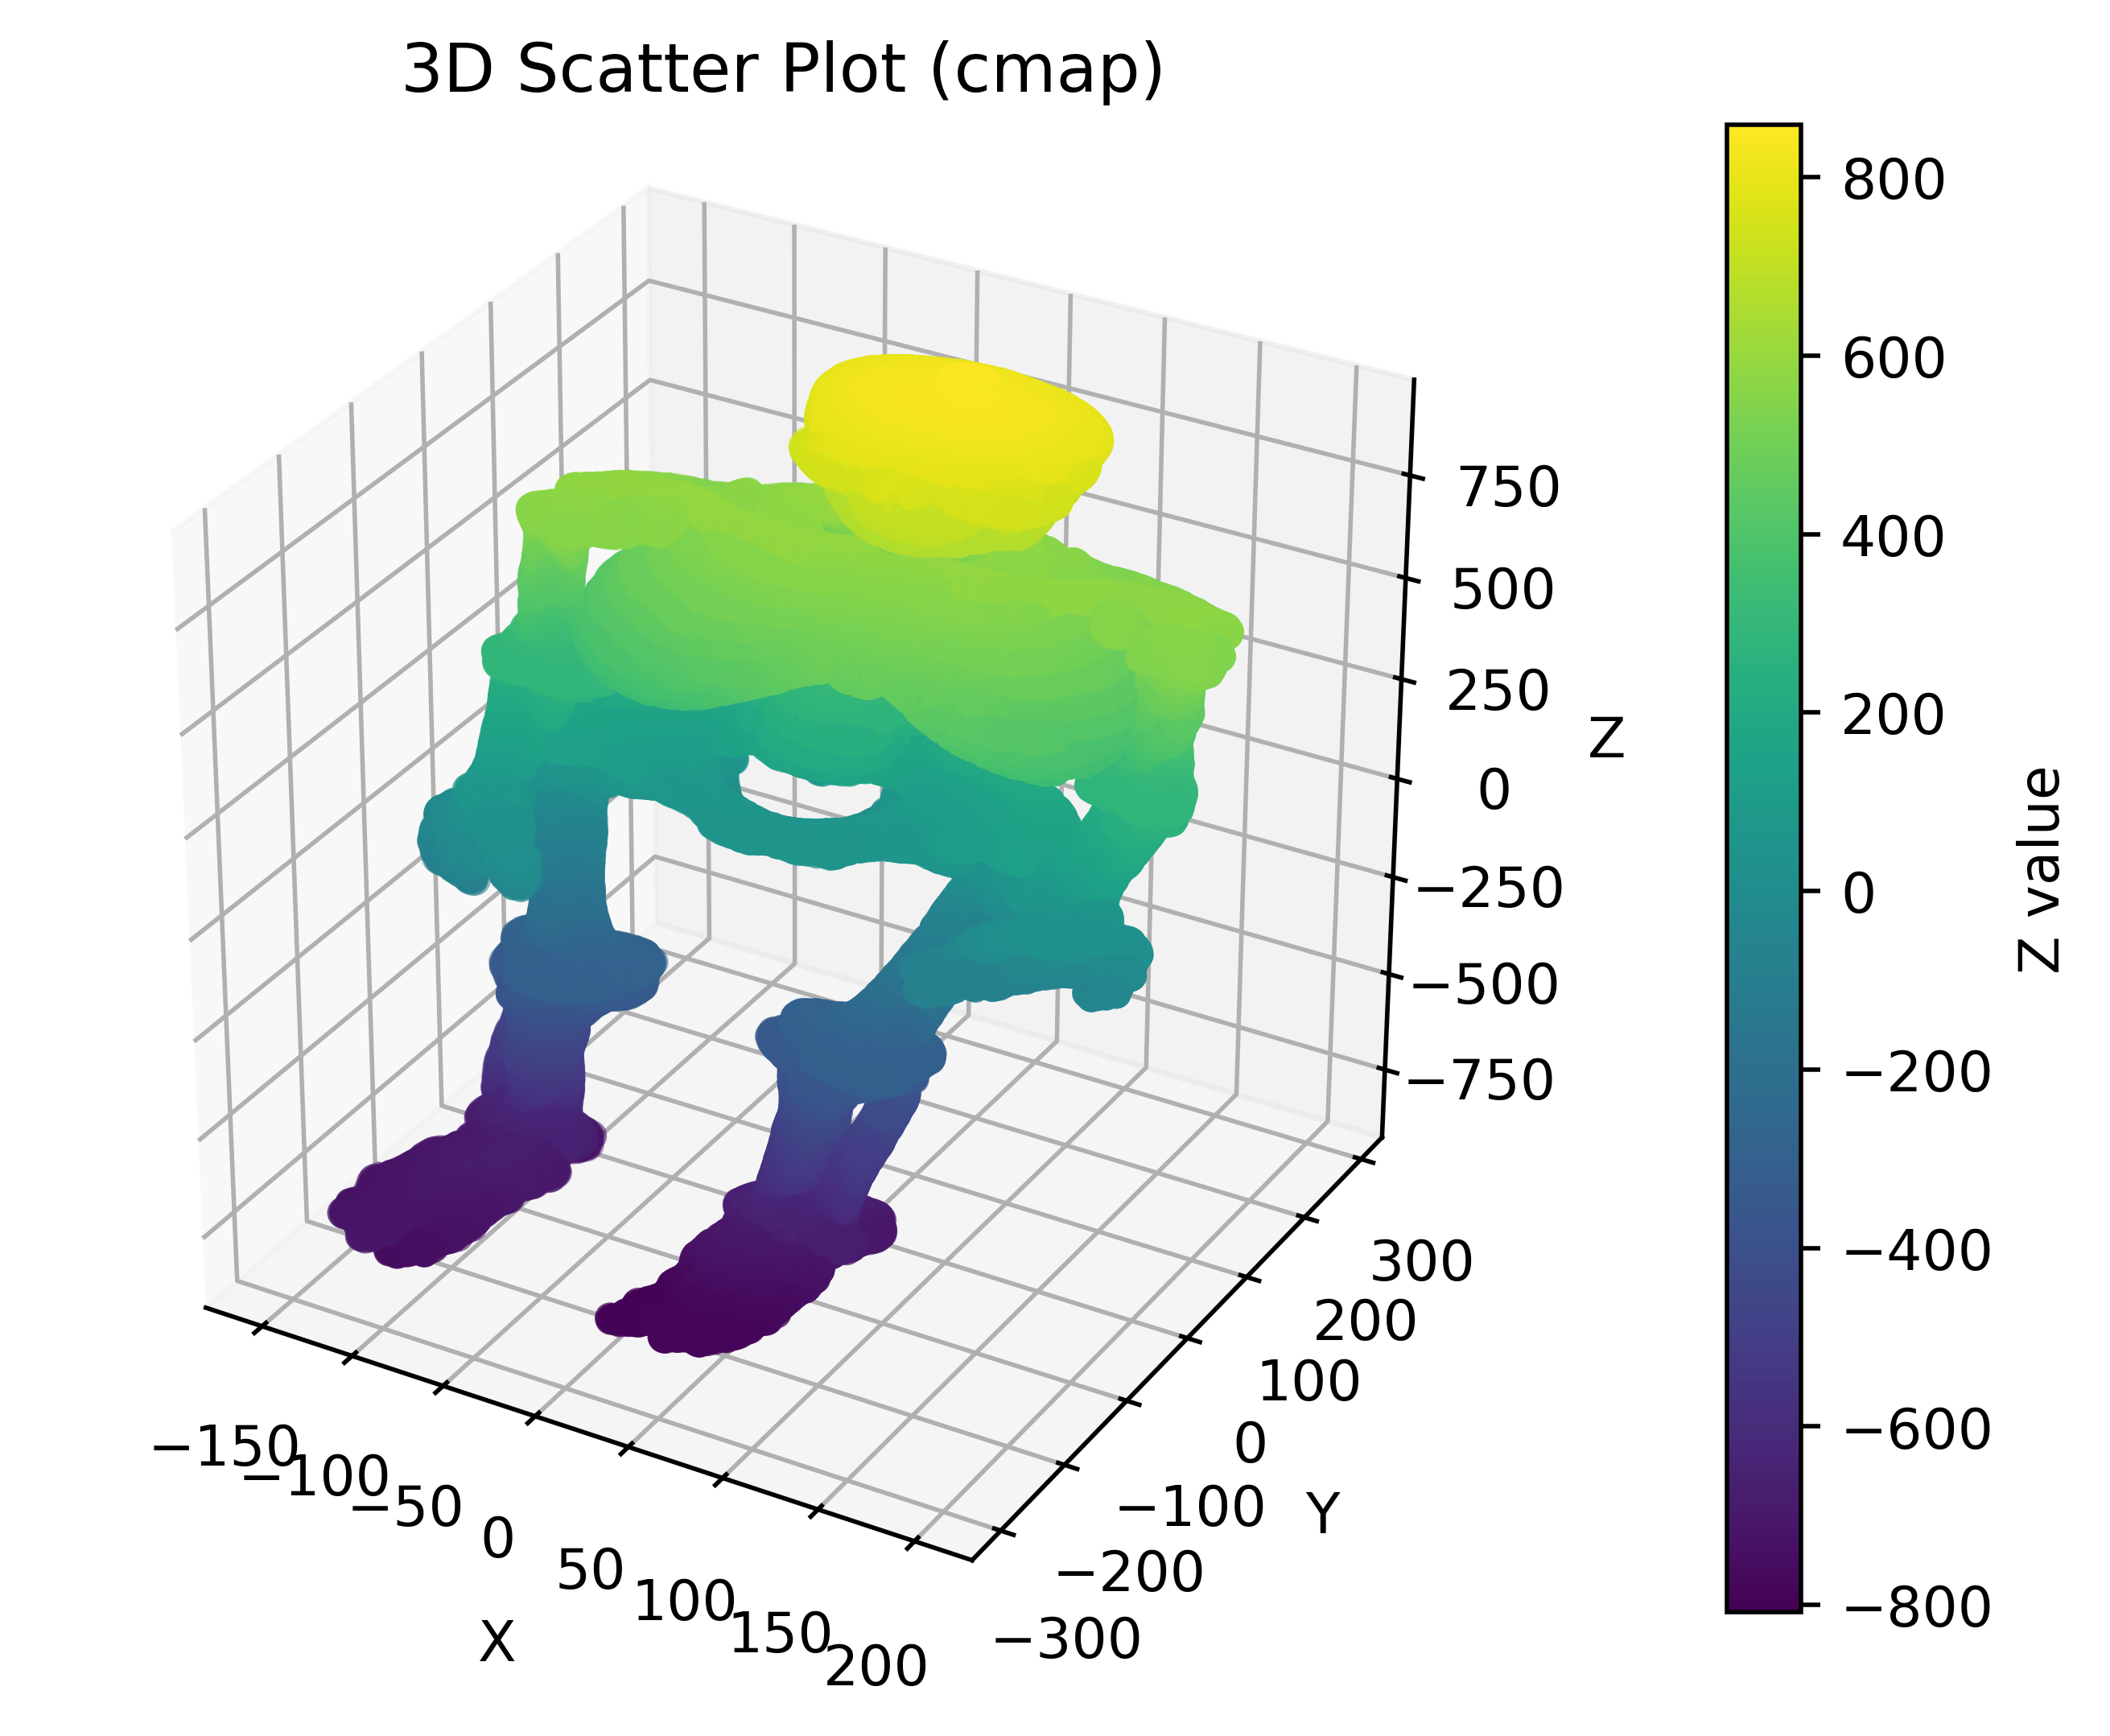

In [17]:
visualize_polygon_from_arr_using_plt(P_3D_array)

In [18]:
reconstructed_point_cloud_array=[]

for i in range(len(P_3D_array)):
    reconstructed_point=P_3D_array[i][:3]
    reconstructed_point_cloud_array.append(reconstructed_point)
    
reconstructed_point_cloud_array=np.array(reconstructed_point_cloud_array)

In [19]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(reconstructed_point_cloud_array)
o3d.visualization.draw_geometries([pcd])

## Linear Reconstruction with Gaussian noise (with N=2 cameras)

We will now look at a more realistic simulation where we have added added Gaussian noise to our points in the 2D projected image, of form $N_G\sim\mathcal{N}(0,7.5)$. A high standard deviation accounts for a significant noise in the 2D image that has high dimensions.

#### Limitation of additive noise:
The main limitation of random noise added to the image or camera matrices implies that there will be no exact solution of the previously established matrix equations. Thus, it requires a large number of runs to find a distibution that will result in a different solution after inducing noise in the 2D image matrices.

In [20]:
with open('PKL/saved_points_reconstructed_noisy_linear.pkl', 'rb') as file:
    recon = pickle.load(file)

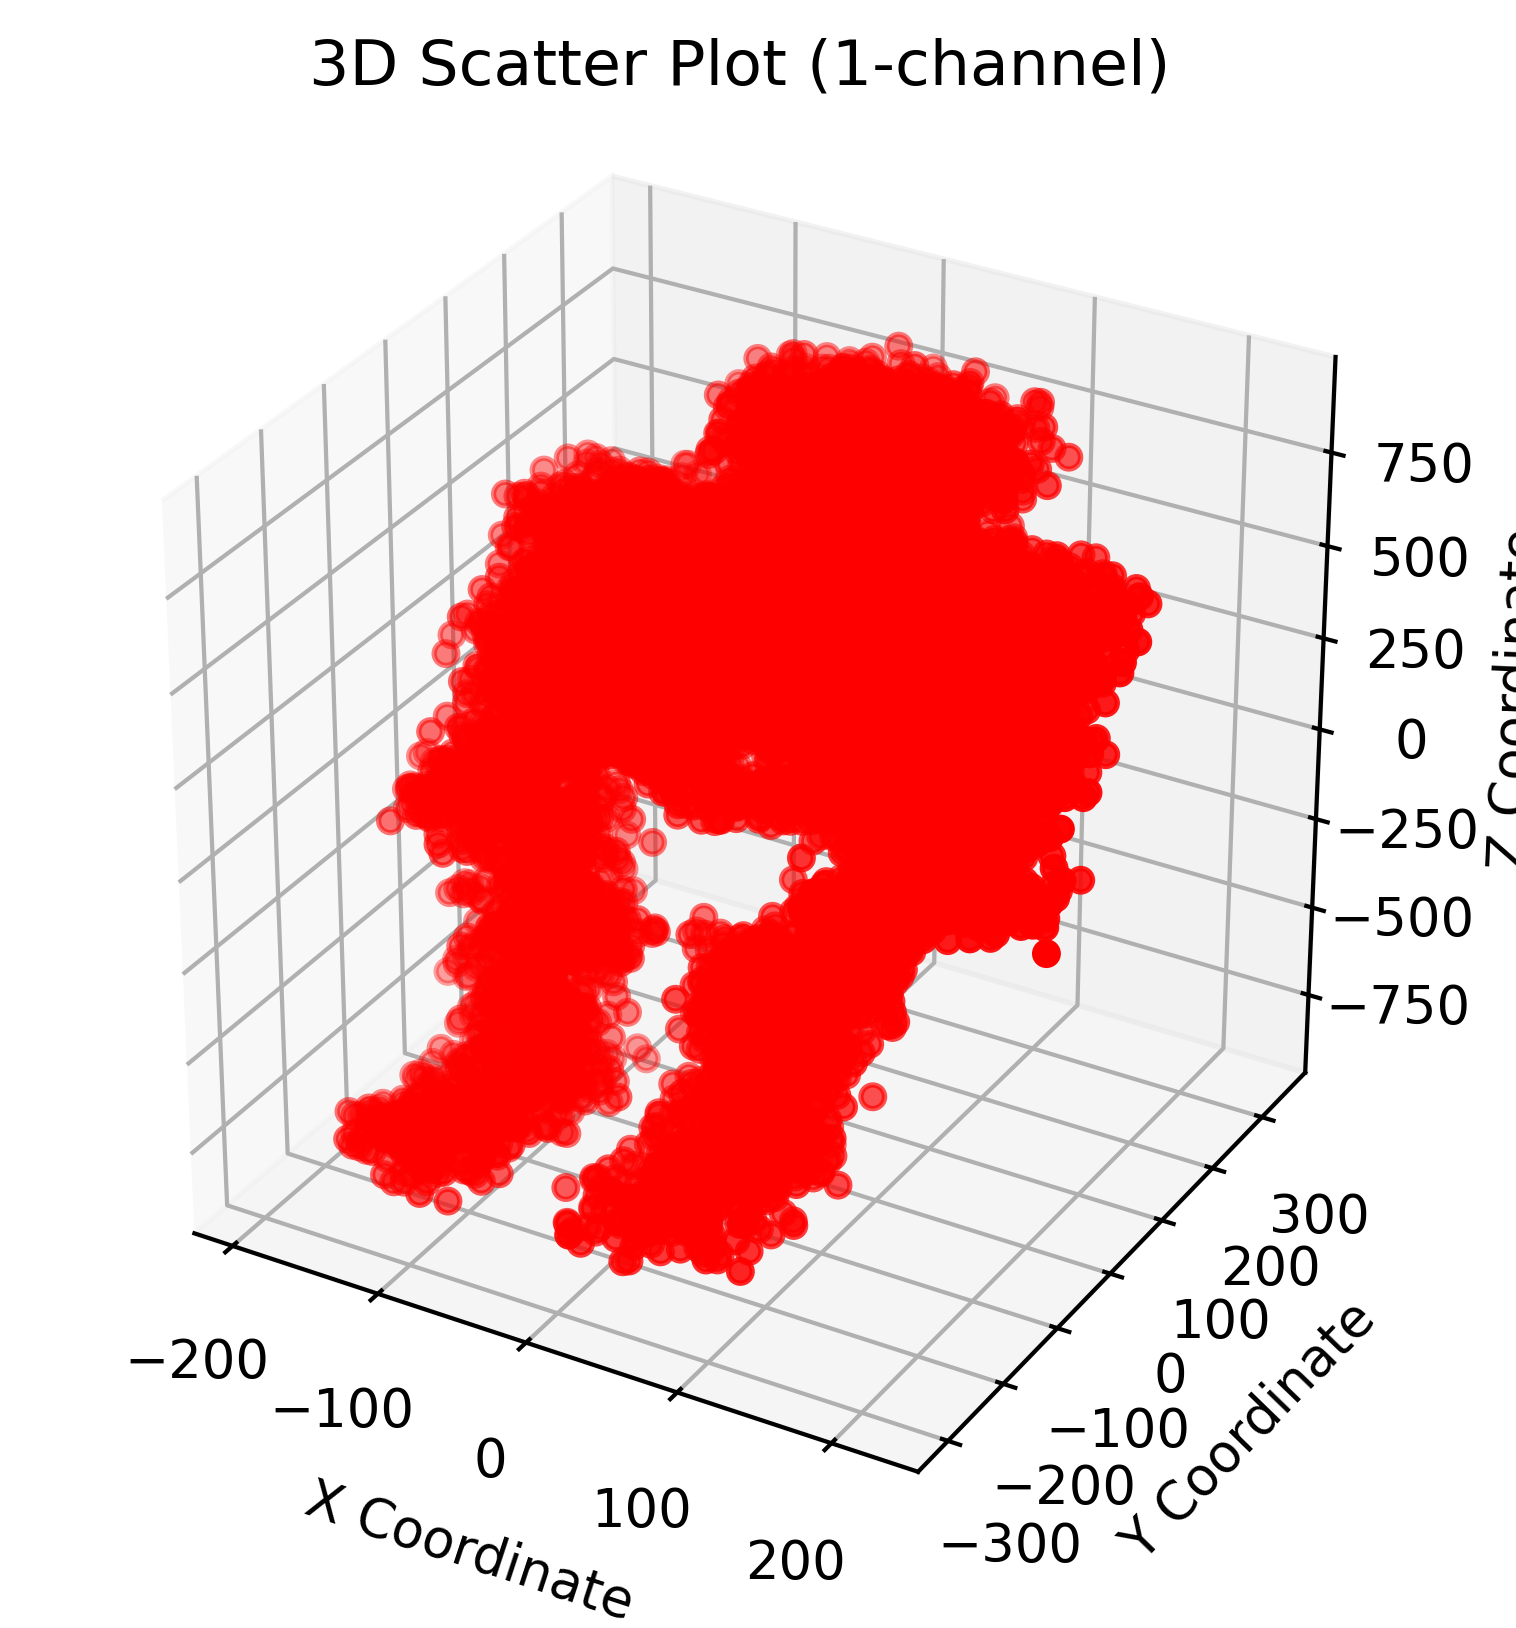

In [21]:
visualize_polygon_from_arr_using_plt(recon)

In [22]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(recon)
o3d.visualization.draw_geometries([pcd])

# Nonlinear Reconstructor

Here, we will see the action of a nonlinear optimization problem formulation that helps overcome the limitations of Direct Linear Transformation.

As soon as we added noise (which is $n_G\in N_{G}\sim\mathcal{N}(0,7.5)$) to the 2D images, it can be written,

$$
\begin{equation}
% p_{err} = p+n_G = MP+n_G = (x_{err},y_{err},1)\\
\hat{p} = p+n_G = MP+n_G = (x,y,1)+n_G = (\hat{x},\hat{y},1) 
\end{equation}
$$

where:
- $\hat{p}$ is an erroneous point in the 2D image
- $p$ is the previously found noiseless point in the 2D image
- $M$ is the camera matrix
- $P$ is the true 3D point
- $(\hat{x},\hat{y})$ and $(x,y)$ are the erroneous and the noiseless 2D points respectively

Therefore, in this case, 
$$
\begin{equation}
\hat{p} \neq MP
\end{equation}
$$



Further, from DLT, we obtain some erroneous 3D point, $\hat{P}$, from the reprojection of $\hat{p}$ with $M$,

$$
\begin{equation}
\hat{p} = M\hat{P}
\end{equation}
$$

Now, we must reduce the distance between our erroneous points in the 2D image plane, which formulates itself as,

$$
\begin{equation}
\begin{array}{rrclcl}
\displaystyle \min_{\hat{P}} & \|M\hat{P}-p\|^2\\
% \textrm{s.t.} \\
% &\xi\geq0    \\
\end{array}
\end{equation}
$$

Here, the erroneous 3D point $\hat{P}$ is interpreted as the <u>guess or estimate of the minimization at a given iteration</u>. Now for $N$ cameras and hence, $N$ 2D images, we can rewrite this problem as the aggregation of each camera's error for that particular point $P_i$,

$$
\begin{equation}
\begin{array}{rrclcl}
\displaystyle \min_{\hat{P}} & \|M\hat{P_1}-p_1\|^2+\|M\hat{P_2}-p_2\|^2+\cdots+\|M\hat{P_N}-p_N\|^2\\
\end{array}\\
\end{equation}
$$
which can be further simplified as, 

$$
\begin{equation}
\begin{array}{rrclcl}
\displaystyle \min_{\hat{P}} & \sum_{i=1}^{N} \|M\hat{P_i}-p_i\|^2\\
\end{array}
\end{equation}
$$


## Gauss Newton method

In order to solve the nonlinear minimization problem, we have to represent the minimization objective through a specific residual function, $r(x)$, to avail the Gauss-Newton algorithm for nonlinear least squares. The general nonlinear least squares problem is to find an $x\in \mathbb{R}^n$ that minimizes,
$$
\begin{equation}
\|r(x)\|^2=\sum_{i=1}^{m} r_i(x)^2
\end{equation}
$$
Here, $r:\mathbb{R}^n\rightarrow\mathbb{R}^m$ such that $r(x)=f(x)-y$ for some input $x$ to a function $f$ with expected output $y$

Let us adopt this framework for our problem. For that, define our reprojection error vector as, $e^i$ for the $i^{th}$ camera, where $e_i=M\hat{P}_i-p_i$, is a $2\times1$ vector (since here we are taking the inhomogeneous representation of the 2D image). Now, our objective function for the minimization problem becomes,

$$
\begin{equation}
\begin{array}{rrclcl}
\displaystyle \min_{\hat{P}} & \sum_{i=1}^{N} e_i(\hat{P})^2\\
\end{array}\\
\end{equation}
$$
where, $e$ is a function of the estimate of the 3D point, $\hat{P}$, with its true value known to be at $P$.

For Gauss Newton method, we need to start with an initial estimate from which the algorithm can improve upon. <u>This initial estimate is found from the solutions of the linear system of equations explained earlier</u>. 

#### Update equation of Gauss Newton algorithm:

$$
\begin{equation}
\hat{P}_{t}=\hat{P}_{t-1}+\delta_P
\end{equation}
$$

Till now, we have a nonlinear least squares problem to minimize. Now, the $\delta_P$ is chosen such that we can linearize the approximate the residual function near the current estimate $\hat{P}$.

Thus, the residual function becomes,
$$
\begin{equation}
e(\hat{P}+\delta_P)\approx e(\hat{P})+\frac{\partial e}{\partial P}\delta_P
\end{equation}
$$
After the linear approximation, objective of the minimization problem becomes,

$$
\begin{equation}
\begin{array}{rrclcl}
\displaystyle \min_{\delta_{P}} & \|\frac{\partial e}{\partial P}\delta_P-(-e(\hat{P}))\|^2\\
\end{array}
\end{equation}
$$

Now, the format of the optimization problem has taken the shape of a linear least squares problem which we can solve easily. For our problem that deals with triangulation with $N$ cameras, the linear least squares solution is,
$$
\begin{equation}
\delta_P=-(J^TJ)^{-1}J^Te
\end{equation}
$$

where

$$e=
\begin{bmatrix}
e_1\\
\vdots\\
e_N\end{bmatrix}
=
\begin{bmatrix}
M_1\hat{P}-p_1\\
\vdots\\
M_N\hat{P}-p_N\end{bmatrix}
,  \ \ \ \ \ J=
\begin{bmatrix}
\frac{\partial e_1}{\partial \hat{P_1}} & \frac{\partial e_1}{\partial \hat{P_2}} & \frac{\partial e_1}{\partial \hat{P_3}}\\
\vdots & \vdots & \vdots\\
\frac{\partial e_N}{\partial \hat{P_1}} & \frac{\partial e_N}{\partial \hat{P_2}} & \frac{\partial e_N}{\partial \hat{P_3}}
\end{bmatrix}
$$

Here, let us remember the $e_i$ is a $2\times1$ vector, thus making $e$ a $2N\times1$ vector. Thus, the Jacobian, $J$ is a $2N\times3$ matrix

#### Assumptions and conditions:
- Linearization of the residual function near the current estimate of $\hat{P}$
- There must be a maximum number of iterations set for this algorithm

#### Limitations:
- A maximum number of iterations is required since this algorithm has no guarantee of convergence
- Computationally expensive even for small image and camera matrices

In [23]:
with open('PKL/saved_dictionary.pkl', 'rb') as p_array_2d_dict_file:
    p_array_2d_dict = pickle.load(p_array_2d_dict_file)
    
with open('PKL/saved_camera_dictionary.pkl', 'rb') as camera_dict_file:
    camera_dict = pickle.load(camera_dict_file)
    
with open('PKL/saved_points_reconstructed_noisy_linear.pkl', 'rb') as recon_file:
    linear_estimates = pickle.load(recon_file)
    
with open('PKL/saved_points_reconstructed_linear.pkl', 'rb') as rec_file:
    noiseless_linear_estimates = pickle.load(rec_file)

In [24]:
M_cam1 = camera_dict[0]["Camera Matrix"]
M_cam2 = camera_dict[1]["Camera Matrix"]
M_cam3 = camera_dict[2]["Camera Matrix"]
M_cam4 = camera_dict[3]["Camera Matrix"]

In [25]:
M2 = np.copy(M_cam2)
M3 = np.copy(M_cam3)
nonlinear_array = []

for i in range(len(p_array_2d_dict[0]["Data"])):
    p1 = get_homogeneous_representation(True, p_array_2d_dict[0]["Data"][i]).flatten()
    p2 = get_homogeneous_representation(True, p_array_2d_dict[1]["Data"][i]).flatten()
    P_init = get_homogeneous_representation(0, linear_estimates[i].reshape(3,1)).flatten()
    optimized_P = gauss_newton_stereo(P_init, M2, M3, p1, p2)
    nonlinear_array.append(optimized_P)

In [26]:
rescale_to_inhomogeneous(nonlinear_array)

gauss_newton_reconstructed_polygon = np.array(nonlinear_array)

In [27]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(gauss_newton_reconstructed_polygon)
o3d.visualization.draw_geometries([pcd])

<div style="font-family: Times New Roman MS">
    <p><center><b>2022 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)</b></center></p>
<!--     <p><center><u>Topic Presentation</u></center></p> -->
    <h1 style="font-family: Times New Roman; margin-bottom: -10px"><center>Virtual Correspondence: Humans as a Cue for Extreme-View Geometry</center></h1>
     <p><center><i><b>Wei-Chiu Ma$^{1,4}$ Anqi Joyce Yang$^{2,4,5}$ Shenlong Wang$^3$ Raquel Urtasun$^{2,4,5}$ Antonio Torralba$^1$ </b></i></center></p>
     <p><center><b>1</b><i> Massachusetts Institute of Technology,</i><b> 2</b><i> University of Toronto,</i><b> 3</b><i> University of Illinois Urbana-Champaign,</i><b> 4</b><i> Waabi,</i><b> 5</b><i> Vector Institute</i><b></center></p>
 </div>
<!--      <p><center>2022 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)</center></p> -->
 </div>
<!-- <center><img src="figs/UC-Santa-Barbara-seal-Navy RGB.png" width=300px alt="default"/></center> -->

### Concept Overview: Virtual Correspondences

Pair of pixels from two camera images whose camera rays intersect in 3D.

<center><img src="figs/bunny-new-2.png" width=700px alt="default"/></center>

### Pipeline

<center><img src="figs/vc-pipeline-new.png" width=700px alt="default"/></center>

### Results

Human reconstruction from multi-views
<center><img src="figs/Results.png" width=600px alt="default"/></center>

# References

[1] Madsen K., Nielsen H. B, and Tingleff O. <i>"Methods for Non-Linear Least Squares Problems"</i>, 2nd ed. Lyngby, Denmark: IMM, 2004.

[2] Szeliski R. <i>"Computer Vision: Algorithms and Applications"</i> (1st. ed.). Springer-Verlag, Berlin, Heidelberg, 2010
    
[3] Hartley R, Zisserman A. <i>"Multiple View Geometry in Computer Vision"</i>. 2nd ed. Cambridge University Press; 2004.

[4] Ma, W. C., Yang, A. J., Wang, S., Urtasun, R., & Torralba, A. <i>Virtual Correspondence: Humans as a Cue for Extreme-View Geometry</i> 2022 IEEE/CVF Conference on Computer Vision and Pattern Recognition, CVPR 2022 (pp. 15903-15913), 2022.